<a href="https://colab.research.google.com/github/OmarArias-Gaguancela/LOGOS_OAG/blob/main/QuickProt_DIA_DIA_NN_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/OmarArias-Gaguancela/LOGOS_OAG/main/QuickProt DIA.jpg" width="180" height="100">

# **QuickProt-DIA-PIPELINE**: This pipeline aims to analyze and visualize DIA proteomics data using the DIA-NN output table.

# **Requirements:**
# 1. Create a folder in **MyDrive** where analyzed data will be stored
# 2. Save DIA-NN output table **"report.tsv"** in the above created folder



## **DIA proteomics data mining**
- Examines the input table and calculates the neccesary parameters for the plotting of figures
- Converts tsv into csv file
- Headings of each produced table can be observed
- **IMPORTANT**: Only proteotypic peptides are kept as they provide a more accurate representation of the relative abundance of a given protein

In [ ]:
#@title ##**Mounts drive and changes the directory to the folder previously created**

from google.colab import drive
import os
from IPython.display import display
import ipywidgets as widgets

# Mount Google Drive
drive.mount('/content/drive')

# Create a text input widget with a longer line
folder_input = widgets.Text(
    value='',
    placeholder='Enter the name of the folder you created',
    description='Folder:',
    layout=widgets.Layout(width='50%')
)

# Display the widget
display(folder_input)

# Function to change directory based on user input
def change_directory(change):
    folder_name = change['new']
    os.chdir(f'/content/drive/MyDrive/{folder_name}')
    print(f"Current directory: {os.getcwd()}")

# Link the widget to the function
folder_input.observe(change_directory, names='value')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(value='', description='Folder:', layout=Layout(width='50%'), placeholder='Enter the name of the folder yo…

Current directory: /content/drive/MyDrive/QUICKPROT_FOR_MANUSCRIPT/DIA_DIA-NN_INPUT


In [ ]:
#@title **Install neccesary packages**
import os

os.system('pip install joypy > /dev/null 2>&1')
os.system('pip install pandas numpy statsmodels compactletterdisplay > /dev/null 2>&1')
os.system('pip install -U scikit-learn > /dev/null 2>&1')
os.system('pip install scikit-posthocs > /dev/null 2>&1')
os.system('pip install gprofiler-official > /dev/null 2>&1')
os.system('pip install missingpy > /dev/null 2>&1')
os.system('pip install --upgrade scikit-learn > /dev/null 2>&1')
os.system('pip install fastcluster > /dev/null 2>&1')
os.system('pip install venn > /dev/null 2>&1')
os.system('pip install matplotlib_venn > /dev/null 2>&1')
os.system('pip install pandas scipy plotly > /dev/null 2>&1')
os.system('pip install -U kaleido > /dev/null 2>&1')
os.system('pip install plotly --upgrade > /dev/null 2>&1')

print("Packages were installed successfully.")
os.makedirs('PLOTS', exist_ok=True)


Packages were installed successfully.


In [ ]:
#@title **Data trimming: sample and group name selection**


import pandas as pd
from IPython.display import display
import ipywidgets as widgets

display(widgets.HTML("<h3>Select samples to analyze</h3>"))

output_dir = 'TABLES'
os.makedirs(output_dir, exist_ok=True)

output_dir = 'PLOTS'
os.makedirs(output_dir, exist_ok=True)

file_path = 'report.tsv'
df = pd.read_csv(file_path, sep='\t')

column_mapping = {'Run': 'Sample'}
df.rename(columns=column_mapping, inplace=True)

#FILTERS
df = df[df['Proteotypic'] == 1]
df = df[~df['Protein.Ids'].str.contains(';')]

samples = df['Sample'].unique().tolist()


checkboxes = [widgets.Checkbox(value=False, description=sample, layout=widgets.Layout(width='auto'), style={'font_weight': 'bold', 'font_size': '16px'}) for sample in samples]
select_all_checkbox = widgets.Checkbox(value=False, description='Select All', layout=widgets.Layout(width='auto'), style={'font_weight': 'bold', 'font_size': '16px'})


def on_select_all_change(change):
    for cb in checkboxes:
        cb.value = change['new']

select_all_checkbox.observe(on_select_all_change, names='value')


checkboxes_box = widgets.VBox([select_all_checkbox] + checkboxes, layout=widgets.Layout(overflow='visible', flex_flow='column wrap', height='auto', max_height='none'))


def on_button_click(b):
    selected_samples = [cb.description for cb in checkboxes if cb.value]
    filtered_df = df[df['Sample'].isin(selected_samples)].copy()

    display(widgets.HTML("<h3>Shortening the name of your sample is recommended, especially when the sample’s name is long, making it visually easier to read in figures/plots.</h3>"))

    shorten_yes_button = widgets.Button(description="Yes", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto', height='40px'))
    shorten_no_button = widgets.Button(description="No", style={'font_weight': 'bold', 'button_color': '#F44336', 'font_size': '16px'}, layout=widgets.Layout(width='auto', height='40px'))

    def on_shorten_yes(b):
        name_inputs = [widgets.Text(value=sample, description=sample, layout=widgets.Layout(width='auto', description_width='initial'), style={'description_width': 'initial', 'font_size': '16px'}) for sample in selected_samples]
        name_inputs_box = widgets.VBox(name_inputs)

        def on_save_names(b):
            new_names = {inp.description: inp.value for inp in name_inputs}
            filtered_df.loc[:, 'Sample'] = filtered_df['Sample'].map(new_names)
            select_group_names(filtered_df)

        save_names_button = widgets.Button(description="Save Names", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto', height='80px'))
        save_names_button.on_click(on_save_names)

        display(name_inputs_box, save_names_button)

    def on_shorten_no(b):
        select_group_names(filtered_df)

    shorten_yes_button.on_click(on_shorten_yes)
    shorten_no_button.on_click(on_shorten_no)

    display(shorten_yes_button, shorten_no_button)

def select_group_names(filtered_df):
    group_name_input = widgets.Text(
        value='',
        placeholder='Enter group name',
        description='Group name:',
        layout=widgets.Layout(width='auto', description_width='initial'),
        style={'description_width': 'initial', 'font_size': '16px'}
    )

    display(widgets.HTML("""
    <h3>Assign a group name to the samples/replicates in your experiment.<br>
    Select multiple samples by pressing the ctrl button on your keyboard. Then click on "Add Group".<br>
    Add as many groups as needed. When finished, please click on "Save CSV file".</h3>
    """))

    group_dropdowns = widgets.SelectMultiple(
        options=filtered_df['Sample'].unique().tolist(),
        description='Select samples:',
        layout=widgets.Layout(overflow='visible', flex_flow='column wrap', height='auto', max_height='none'),
        style={'description_width': 'initial', 'font_size': '16px'}
    )

    assigned_samples = set()

    def on_add_group(b):
        group_name = group_name_input.value
        selected_samples_for_group = list(group_dropdowns.value)
        filtered_df.loc[filtered_df['Sample'].isin(selected_samples_for_group), 'Experimental groups'] = group_name

        assigned_samples.update(selected_samples_for_group)
        remaining_samples = [sample for sample in filtered_df['Sample'].unique() if sample not in assigned_samples]
        group_dropdowns.options = remaining_samples

        group_name_input.value = ''

    add_group_button = widgets.Button(description="Add Group", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto', height='40px'))
    add_group_button.on_click(on_add_group)

    save_csv_button = widgets.Button(description="Save CSV file", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto', height='40px'))

    def on_save_csv(b):
        filtered_df.to_csv('TABLES/report_updated.csv', index=False)

        group_dropdowns.options = []

    save_csv_button.on_click(on_save_csv)

    display(group_name_input, group_dropdowns, add_group_button, save_csv_button)

display(checkboxes_box)
button = widgets.Button(description="Submit", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto', height='40px'))
button.on_click(on_button_click)
display(button)



HTML(value='<h3>Select samples to analyze</h3>')

Button(description='Submit', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color='#4CAF…

HTML(value='<h3>Shortening the name of your sample is recommended, especially when the sample’s name is long, …

Button(description='Yes', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color='#4CAF50'…

Button(description='No', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color='#F44336',…

Button(description='Save Names', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_color='#…

HTML(value='\n    <h3>Assign a group name to the samples/replicates in your experiment.<br>\n    Select multip…

Text(value='', description='Group name:', layout=Layout(width='auto'), placeholder='Enter group name', style=D…

SelectMultiple(description='Select samples:', layout=Layout(flex_flow='column wrap', height='auto', max_height…

Button(description='Add Group', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color='#4…

Button(description='Save CSV file', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color…

##**Selection of minimum number of peptides per protein (OPTIONAL)**



In [ ]:
#@title **Peptide threshold**
import pandas as pd

file_path = 'TABLES/report_updated.csv'
df = pd.read_csv(file_path, delimiter=',')
def filter_dataframe(min_peptides):
    peptide_counts = df.groupby(['Protein name', 'Sample'])['Peptide'].transform('nunique')
    filtered_df = df[peptide_counts >= min_peptides]

    return filtered_df
min_peptides = int(input("Enter the minimum number of peptides: "))
filtered_df = filter_dataframe(min_peptides)
filtered_df.to_csv(file_path, sep=',', index=False)

print(f"The file has been updated with proteins with at least {min_peptides} peptides.")

##**Tables with calculated parameters for plots**


## **Metrics to be calculated**
- Calculates the number of proteins and peptides in a data set
- Calculates the mean, median, standard deviation, and coefficient of variation
- Pivots tables, this makes it easier when plotting heatmaps
- Calculates the number of peptides utlized to determine the relative abundance of a given protein


In [ ]:
#@title **Peptide count table**
import pandas as pd

df = pd.read_csv('TABLES/report_updated.csv')
df = df.drop_duplicates(subset=['Sample', 'Experimental groups', 'Stripped.Sequence'])
counts = df.groupby(['Sample', 'Experimental groups'])['Stripped.Sequence'].count().reset_index()
counts.columns = ['Sample', 'Experimental groups', 'Number of peptides']
counts.to_csv('TABLES/peptide_counts.csv', index=False)
print(f"Report was saved as: TABLES/peptide_counts.csv")
counts.head()



Report was saved as: TABLES/peptide_counts.csv


,Sample,Experimental groups,Number of peptides
0,D0_rep1,D0,19053
1,D0_rep2,D0,20903
2,D10_rep1,D10,30499
3,D10_rep2,D10,30739
4,D11_rep1,D11,31170


In [ ]:
#@title **Protein count table**
import pandas as pd

df = pd.read_csv('TABLES/report_updated.csv')
df = df.drop_duplicates(subset=['Protein.Names', 'Protein.Ids', 'Sample', 'Genes'])
counts = df.groupby(['Sample', 'Experimental groups'])['Protein.Names'].nunique().reset_index()
counts.columns = ['Sample', 'Experimental groups', 'Number of proteins']
counts.to_csv('TABLES/protein_counts.csv', index=False)
print(f"Report was saved as: TABLES/protein_counts.csv")
counts.head()



Report was saved as: TABLES/protein_counts.csv


,Sample,Experimental groups,Number of proteins
0,D0_rep1,D0,3710
1,D0_rep2,D0,3860
2,D10_rep1,D10,4915
3,D10_rep2,D10,4938
4,D11_rep1,D11,4999


In [ ]:
#@title **Quantitative parameters for experimental groups**
import pandas as pd

df = pd.read_csv('TABLES/report_updated.csv')

df['Median Abundance'] = df.groupby(['Experimental groups', 'Protein.Names'])['Genes.MaxLFQ.Unique'].transform('median')
df['Mean Abundance'] = df.groupby(['Experimental groups', 'Protein.Names'])['Genes.MaxLFQ.Unique'].transform('mean')
df['Standard Deviation'] = df.groupby(['Experimental groups', 'Protein.Names'])['Genes.MaxLFQ.Unique'].transform('std')
df['Coefficient of Variation'] = (df['Standard Deviation'] / df['Mean Abundance']) * 100
df.rename(columns={'Protein.Ids': 'Protein IDs', 'Protein.Names': 'Protein name'}, inplace=True)
result = df[['Protein name', 'Protein IDs', 'Genes', 'Experimental groups', 'Sample', 'Genes.MaxLFQ.Unique', 'Median Abundance', 'Standard Deviation', 'Coefficient of Variation']]
result = result.drop_duplicates(subset=['Sample','Protein name'])
result.to_csv('TABLES/Quantitative_parameters.csv', index=False)
print(f"Report was saved as: TABLES/Quantitative_parameters.csv")
result.head()


Report was saved as: TABLES/Quantitative_parameters.csv


,Protein name,Protein IDs,Genes,Experimental groups,Sample,Genes.MaxLFQ.Unique,Median Abundance,Standard Deviation,Coefficient of Variation
0,SRP14_HUMAN,P37108,SRP14,D0,D0_rep1,29287900.0,24615850.0,4.924773e+06,20.006513
1,SRP14_HUMAN,P37108,SRP14,D0,D0_rep2,19943800.0,24615850.0,4.924773e+06,20.006513
2,SRP14_HUMAN,P37108,SRP14,D2,D2_rep2,33989700.0,33989700.0,6.653091e+06,23.593420
3,SRP14_HUMAN,P37108,SRP14,D4,D4_rep2,23516400.0,23516400.0,4.366808e+06,22.149017
4,SRP14_HUMAN,P37108,SRP14,D6,D6_rep1,19367900.0,19367900.0,1.410238e+06,6.847359


In [ ]:
#@title **Pivoted table for median protein abundance in experimental groups**
import pandas as pd

df = pd.read_csv('TABLES/Quantitative_parameters.csv')
df = df.drop_duplicates(subset=['Protein name', 'Protein IDs', 'Experimental groups', 'Genes'])
pivot_df = df.pivot_table(index=['Protein name', 'Protein IDs', 'Genes'], columns=['Experimental groups'], values='Median Abundance', aggfunc='first')
pivot_df.columns = [col for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)
pivot_df.to_csv('TABLES/median_abundance.csv', index=False)
print(f"Report was saved as: TABLES/median_abundance.csv")
pivot_df.head()


Report was saved as: TABLES/median_abundance.csv


,Protein name,Protein IDs,Genes,D0,D10,D11,D12,D14,D2,D4,D6,D8
0,1433B_HUMAN,P31946,YWHAB,22372300.0,13875400.0,18339000.0,13651200.0,10753600.0,9023520.0,16375500.0,17052700.0,11010590.0
1,1433E_HUMAN,P62258,YWHAE,44643100.0,11357100.0,22323200.0,29102300.0,21719700.0,10975905.0,24700800.0,19238100.0,15861600.0
2,1433F_HUMAN,Q04917,YWHAH,4174070.0,3516030.0,4836020.0,8530820.0,6505410.0,2727095.0,4159345.0,3295870.0,4680740.0
3,1433G_HUMAN,P61981,YWHAG,22307600.0,11720650.0,17914200.0,26475250.0,19559650.0,9638945.0,19499600.0,12651500.0,9972055.0
4,1433S_HUMAN,P31947,SFN,31550700.0,NaN,30140500.0,NaN,37469000.0,25190000.0,17358700.0,25227850.0,22885200.0


In [ ]:
#@title **Pivoted table for coeficients of variation (CVs) in experimental groups**
import pandas as pd
df = pd.read_csv('TABLES/Quantitative_parameters.csv')
df = df.drop_duplicates(subset=['Protein name', 'Protein IDs', 'Experimental groups', 'Genes'])
pivot_df = df.pivot_table(index=['Protein name', 'Protein IDs', 'Genes'], columns=['Experimental groups'], values='Coefficient of Variation', aggfunc='first')
pivot_df.columns = [col for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)
pivot_df.to_csv('TABLES/CVs.csv', index=False)
print(f"Report was saved as: TABLES/CVs.csv")
pivot_df.head()

Report was saved as: TABLES/CVs.csv


,Protein name,Protein IDs,Genes,D0,D10,D11,D12,D14,D2,D4,D6,D8
0,1433B_HUMAN,P31946,YWHAB,12.519012,10.984459,14.488856,6.380815,51.757283,11.594929,22.533529,15.342334,17.838292
1,1433E_HUMAN,P62258,YWHAE,23.340817,15.979038,5.539910,0.067404,10.488475,11.013645,29.376178,8.339327,11.584394
2,1433F_HUMAN,Q04917,YWHAH,4.368057,2.376871,9.800395,13.478572,17.166336,24.610110,26.163533,16.643002,31.101537
3,1433G_HUMAN,P61981,YWHAG,15.198749,4.513546,11.956125,11.885770,21.895318,22.357683,26.753189,20.797181,22.524022
4,1433S_HUMAN,P31947,SFN,25.379528,NaN,NaN,NaN,NaN,NaN,123.266578,26.951109,20.063922


In [ ]:
#@title **Number of peptides per protein for samples/replicates and experimental groups**
import pandas as pd

file_path = 'TABLES/report_updated.csv'
df = pd.read_csv(file_path)

# Count peptides per protein per sample
filtered_df_sample = df[df['Sample'].notnull()]
counts_sample = filtered_df_sample.groupby(['Protein.Group', 'Protein.Names', 'Genes', 'Sample'])['Stripped.Sequence'].nunique().reset_index()
counts_sample.columns = ['Protein.Group', 'Protein.Names', 'Genes', 'Sample', '#Peptides per protein']
counts_sample.rename(columns={'Protein.Group': 'Protein IDs', 'Protein.Names': 'Protein name'}, inplace=True)
counts_sample_file = 'TABLES/number_peptides_per_protein_per_sample.csv'
counts_sample.to_csv(counts_sample_file, index=False)
print(f"Report was saved as: {counts_sample_file}")

# Count peptides per protein per experimental group
filtered_df_group = df[df['Experimental groups'].notnull()]
counts_group = filtered_df_group.groupby(['Protein.Group', 'Protein.Names', 'Genes', 'Experimental groups'])['Stripped.Sequence'].nunique().reset_index()
counts_group.columns = ['Protein.Group', 'Protein.Names', 'Genes', 'Experimental groups', '#Peptides per protein']
counts_group.rename(columns={'Protein.Group': 'Protein IDs', 'Protein.Names': 'Protein name'}, inplace=True)
counts_group_file = 'TABLES/number_peptides_per_protein_per_group.csv'
counts_group.to_csv(counts_group_file, index=False)
print(f"Report was saved as: {counts_group_file}")

# Pivot the data
df_pivot = pd.read_csv(counts_group_file)
df_pivot = df_pivot[['Protein name', 'Protein IDs', 'Genes', '#Peptides per protein', 'Experimental groups']]
pivot_df = df_pivot.pivot_table(index=['Protein name', 'Protein IDs', 'Genes'], columns=['Experimental groups'], values='#Peptides per protein', aggfunc='first')
pivot_df.reset_index(inplace=True)
pivot_df.drop_duplicates(subset=['Protein name'], inplace=True)
pivot_df_file = 'TABLES/melted_number_peptides_per_protein_per_group.csv'
pivot_df.to_csv(pivot_df_file, index=False)
print(f"Report was saved as: {pivot_df_file}")

Report was saved as: TABLES/number_peptides_per_protein_per_sample.csv
Report was saved as: TABLES/number_peptides_per_protein_per_group.csv
Report was saved as: TABLES/melted_number_peptides_per_protein_per_group.csv


In [ ]:
#@title **Shared and unique proteins**
import os
import pandas as pd
from itertools import combinations
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

os.makedirs('TABLES/SHARED_UNIQUE_PROTEINS', exist_ok=True)
df = pd.read_csv('TABLES/median_abundance.csv')
group_columns = df.columns[3:]
protein_sets = {group: set(df[df[group].notnull()]['Protein name']) for group in group_columns}

shared_unique_table = {
    'Group': [],
    'Shared Proteins': [],
    'Unique Proteins': [],
    'Number of Shared Proteins': [],
    'Number of Unique Proteins': []
}


all_shared = set.intersection(*protein_sets.values())
shared_unique_table['Group'].append('Shared by all groups')
shared_unique_table['Shared Proteins'].append(all_shared)
shared_unique_table['Unique Proteins'].append(set())
shared_unique_table['Number of Shared Proteins'].append(len(all_shared))
shared_unique_table['Number of Unique Proteins'].append(0)

for combo in combinations(group_columns, 2):
    group1, group2 = combo
    shared_proteins = protein_sets[group1].intersection(protein_sets[group2])

    shared_proteins_count = len(shared_proteins) - len(all_shared)
    adjusted_shared_proteins = shared_proteins - all_shared

    shared_unique_table['Group'].append(f'Shared by {group1} and {group2}')
    shared_unique_table['Shared Proteins'].append(adjusted_shared_proteins)
    shared_unique_table['Unique Proteins'].append(set())
    shared_unique_table['Number of Shared Proteins'].append(shared_proteins_count)
    shared_unique_table['Number of Unique Proteins'].append(0)


for group in group_columns:
    unique_proteins = protein_sets[group] - set.union(*[protein_sets[g] for g in group_columns if g != group])
    shared_unique_table['Group'].append(f'Unique to {group}')
    shared_unique_table['Shared Proteins'].append(set())
    shared_unique_table['Unique Proteins'].append(unique_proteins)
    shared_unique_table['Number of Shared Proteins'].append(0)
    shared_unique_table['Number of Unique Proteins'].append(len(unique_proteins))

table_df = pd.DataFrame(shared_unique_table)
table_df.to_csv('TABLES/SHARED_UNIQUE_PROTEINS/shared_unique_proteins.csv', index=False)
print("Shared/unique proteins table saved to 'TABLES/SHARED_UNIQUE_PROTEINS/shared_unique_proteins.csv'.")
table_df.head()


Shared/unique proteins table saved to 'TABLES/SHARED_UNIQUE_PROTEINS/shared_unique_proteins.csv'.


,Group,Shared Proteins,Unique Proteins,Number of Shared Proteins,Number of Unique Proteins
0,Shared by all groups,"{FLOT2_HUMAN, PB1_HUMAN, TBB5_HUMAN, RAP2C_HUM...",{},2752,0
1,Shared by D0 and D10,"{HTF4_HUMAN, RUSD2_HUMAN, SPS1_HUMAN, AT11C_HU...",{},1110,0
2,Shared by D0 and D11,"{NRIP1_HUMAN, RUSD2_HUMAN, HTF4_HUMAN, SPS1_HU...",{},1129,0
3,Shared by D0 and D12,"{NRIP1_HUMAN, MDR1_HUMAN, RUSD2_HUMAN, APOM_HU...",{},923,0
4,Shared by D0 and D14,"{MDR1_HUMAN, LRP1_HUMAN, TM135_HUMAN, K2C4_HUM...",{},169,0


In [ ]:
#@title **Shared and unique proteins files**
import pandas as pd
import os

input_file = 'TABLES/SHARED_UNIQUE_PROTEINS/shared_unique_proteins.csv'
df = pd.read_csv(input_file)

output_dir = 'TABLES/SHARED_UNIQUE_PROTEINS/Extracted'
os.makedirs(output_dir, exist_ok=True)

shared_groups = df[df['Group'].str.startswith('Shared by')]
for index, row in shared_groups.iterrows():
    proteins = row['Shared Proteins'].strip('{}').replace("'", "").split(', ')
    proteins = [protein.strip() for protein in proteins]
    output_file = os.path.join(output_dir, f"{row['Group'].replace(' ', '_')}_shared_proteins.csv")
    pd.DataFrame(proteins, columns=['Protein name']).to_csv(output_file, index=False)

unique_groups = df[df['Group'].str.startswith('Unique to')]
for index, row in unique_groups.iterrows():
    proteins = row['Unique Proteins'].strip('{}').replace("'", "").split(', ')
    proteins = [protein.strip() for protein in proteins]
    output_file = os.path.join(output_dir, f"{row['Group'].replace(' ', '_')}_unique_proteins.csv")
    pd.DataFrame(proteins, columns=['Protein name']).to_csv(output_file, index=False)

print("All files have been exported to TABLES/SHARED_UNIQUE_PROTEINS/Extracted/")




All files have been exported to TABLES/SHARED_UNIQUE_PROTEINS/Extracted/


##**Rearrange the order of groups/samples if needed**

In [ ]:
#@title **Rearrange the order of groups if needed**
#@markdown - Click on "Update" whether reorganization was necessary or not

import pandas as pd
import ipywidgets as widgets
from IPython.display import display

peptide_counts_df = pd.read_csv('TABLES/peptide_counts.csv')
protein_counts_df = pd.read_csv('TABLES/protein_counts.csv')
quantitative_parameters_df = pd.read_csv('TABLES/Quantitative_parameters.csv')
median_abundance_df = pd.read_csv('TABLES/median_abundance.csv')
CVs_df = pd.read_csv('TABLES/CVs.csv')
melted_number_peptides_per_protein_per_group_df = pd.read_csv('TABLES/melted_number_peptides_per_protein_per_group.csv')


group_names = peptide_counts_df['Experimental groups'].unique().tolist()
group_order = widgets.SelectMultiple(
    options=group_names,
    value=tuple(group_names),
    description='Groups:',
    layout=widgets.Layout(width='50%', height='200px'),
    style={'description_width': 'initial'}
)

move_up_button = widgets.Button(description="Move Up", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
move_down_button = widgets.Button(description="Move Down", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
reorder_tables_button = widgets.Button(description="Update groups", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))

def move_up(change):
    selected = list(group_order.value)
    options = list(group_order.options)
    for item in selected:
        idx = options.index(item)
        if idx > 0:
            options[idx], options[idx - 1] = options[idx - 1], options[idx]
            group_order.value = tuple(options)
            group_order.options = options

def move_down(change):
    selected = list(group_order.value)
    options = list(group_order.options)
    for item in reversed(selected):
        idx = options.index(item)
        if idx < len(options) - 1:
            options[idx], options[idx + 1] = options[idx + 1], options[idx]
            group_order.value = tuple(options)
            group_order.options = options

def reorder_tables(change):
    new_order = list(group_order.options)

    peptide_counts_df['Experimental groups'] = pd.Categorical(peptide_counts_df['Experimental groups'], categories=new_order, ordered=True)
    reordered_peptide_counts_df = peptide_counts_df.sort_values('Experimental groups')

    protein_counts_df['Experimental groups'] = pd.Categorical(protein_counts_df['Experimental groups'], categories=new_order, ordered=True)
    reordered_protein_counts_df = protein_counts_df.sort_values('Experimental groups')

    quantitative_parameters_df['Experimental groups'] = pd.Categorical(quantitative_parameters_df['Experimental groups'], categories=new_order, ordered=True)
    reordered_quantitative_parameters_df = quantitative_parameters_df.sort_values('Experimental groups')

    median_abundance_columns = ['Protein name', 'Protein IDs', 'Genes'] + new_order
    reordered_median_abundance_df = median_abundance_df[median_abundance_columns]

    CVs_columns = ['Protein name', 'Protein IDs', 'Genes'] + new_order
    reordered_CVs_df = CVs_df[CVs_columns]

    melted_number_peptides_per_protein_per_group_columns = ['Protein IDs', 'Protein name', 'Genes'] + new_order
    reordered_melted_number_peptides_per_protein_per_group_df = melted_number_peptides_per_protein_per_group_df[melted_number_peptides_per_protein_per_group_columns]

    reordered_peptide_counts_df.to_csv('TABLES/peptide_counts.csv', index=False)
    reordered_protein_counts_df.to_csv('TABLES/protein_counts.csv', index=False)
    reordered_quantitative_parameters_df.to_csv('TABLES/Quantitative_parameters.csv', index=False)
    reordered_median_abundance_df.to_csv('TABLES/median_abundance.csv', index=False)
    reordered_CVs_df.to_csv('TABLES/CVs.csv', index=False)
    reordered_melted_number_peptides_per_protein_per_group_df.to_csv('TABLES/melted_number_peptides_per_protein_per_group.csv', index=False)

move_up_button.on_click(move_up)
move_down_button.on_click(move_down)
reorder_tables_button.on_click(reorder_tables)

controls_box = widgets.VBox([move_up_button, move_down_button, reorder_tables_button])
display(widgets.HBox([group_order, controls_box]))

df = pd.read_csv('TABLES/Quantitative_parameters.csv')
df = df.drop_duplicates(subset=['Protein name', 'Protein IDs', 'Sample', 'Genes'])

sample_names = df['Sample'].unique().tolist()

sample_order = widgets.SelectMultiple(
    options=sample_names,
    value=tuple(sample_names),
    description='Samples:',
    layout=widgets.Layout(width='50%', height='200px'),
    style={'description_width': 'initial'}
)

move_up_sample_button = widgets.Button(description="Move Up", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
move_down_sample_button = widgets.Button(description="Move Down", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
reorder_samples_button = widgets.Button(description="Update samples", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))

def move_up_sample(change):
    selected = list(sample_order.value)
    options = list(sample_order.options)
    for item in selected:
        idx = options.index(item)
        if idx > 0:
            options[idx], options[idx - 1] = options[idx - 1], options[idx]
            sample_order.value = tuple(options)
            sample_order.options = options

def move_down_sample(change):
    selected = list(sample_order.value)
    options = list(sample_order.options)
    for item in reversed(selected):
        idx = options.index(item)
        if idx < len(options) - 1:
            options[idx], options[idx + 1] = options[idx + 1], options[idx]
            sample_order.value = tuple(options)
            sample_order.options = options

def reorder_samples(change):
    new_sample_order = list(sample_order.options)
    pivot_df = df.pivot_table(index=['Protein name', 'Protein IDs', 'Genes'], columns=['Sample'], values='Genes.MaxLFQ.Unique', aggfunc='first')
    pivot_df = pivot_df[new_sample_order]
    pivot_df.reset_index(inplace=True)
    pivot_df.to_csv('TABLES/melted_protein_data_samples.csv', index=False)

move_up_sample_button.on_click(move_up_sample)
move_down_sample_button.on_click(move_down_sample)
reorder_samples_button.on_click(reorder_samples)

sample_controls_box = widgets.VBox([move_up_sample_button, move_down_sample_button, reorder_samples_button])
display(widgets.HBox([sample_order, sample_controls_box]))






##**Coeficient of variation (CV)**
- Generates a violin plot for the CV, and also shows the median CV value for the entire dataset

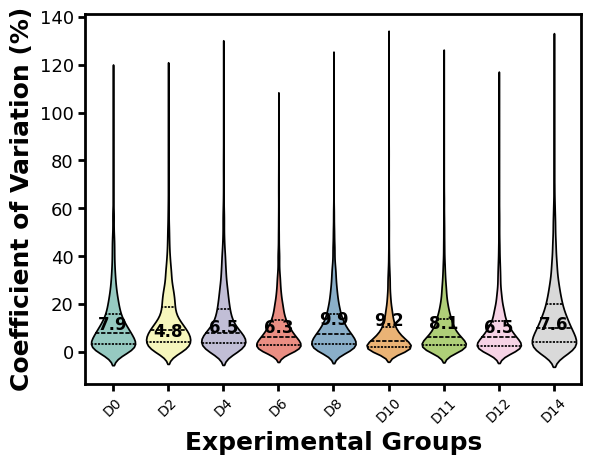

In [ ]:
#@title **CV plot**

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'TABLES/CVs.csv'
df = pd.read_csv(file_path)

plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_data(df):
    group_names = [col for col in df.columns if col not in ['Protein name', 'Protein IDs', 'Genes']]

    melted_df = df.melt(id_vars=['Protein name', 'Protein IDs'], value_vars=group_names, var_name='Group', value_name='Value')

    median_df = melted_df.groupby('Group')['Value'].median().reset_index()
    median_df.columns = ['Group', 'Median Value']
    melted_df = melted_df.merge(median_df, on='Group')

    sns.violinplot(x='Group', y='Value', hue='Group', data=melted_df, inner='quartile', palette='Set3', edgecolor='black', legend=False)
    for i, row in median_df.iterrows():
        plt.text(i, row['Median Value'], f'{row["Median Value"]:.1f}', horizontalalignment='center', verticalalignment='bottom', fontsize=12, fontweight='bold')

    plt.ylabel('Coefficient of Variation (%)', fontsize=18, fontweight='bold')
    plt.xlabel('Experimental Groups', fontsize=18, fontweight='bold')
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=13)

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    plt.savefig('PLOTS/CV_violin_plot.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

plot_data(df)


##**Correlation among replicates**
- Plots the distribution of the dataset
- Calculates the Spearman's rank correlation coeficient among replicates

Text(value='', description='Samples:', layout=Layout(width='auto'), placeholder='Separated by commas (up to 3)…

Button(description='Plot Data', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_color='#4…

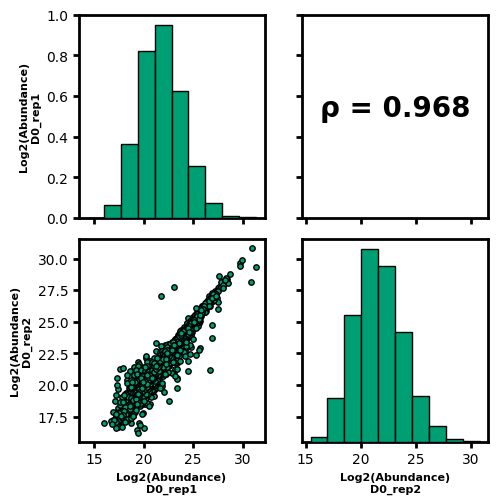

In [ ]:
#@title **Select samples for correlation plot**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/melted_protein_data_samples.csv'
df = pd.read_csv(file_path)

columns_input = widgets.Text(
    value='',
    placeholder='Separated by commas (up to 3)',
    description='Samples:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)


button = widgets.Button(description="Plot Data", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(
                width='auto',
                height='80px'
            ))

def update_plot(columns):
    columns_to_plot = [col.strip() for col in columns.split(',') if col.strip() in df.columns]
    if len(columns_to_plot) > 3:
        print("Please enter up to three column names.")
        return

    df[columns_to_plot] = np.log2(df[columns_to_plot])

    def annotate_corr(x, y, **kwargs):
        valid_idx = x.notna() & y.notna()
        x_valid = x[valid_idx]
        y_valid = y[valid_idx]

        if len(x_valid) > 1 and len(y_valid) > 1:
            rho, _ = spearmanr(x_valid, y_valid)
        else:
            rho = np.nan

        ax = plt.gca()
        x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
        y_pos = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
        ax.annotate(f'ρ = {rho:.3f}', xy=(x_pos, y_pos), xycoords='data', ha='center', fontsize=20, fontweight='bold')

    g = sns.PairGrid(df, vars=columns_to_plot, diag_sharey=False)
    g.map_diag(plt.hist, bins=10, edgecolor='black', color='#009E73')
    g.map_lower(plt.scatter, color='#009E73', edgecolor='black', s=15)
    g.map_upper(annotate_corr)

    for ax in g.axes.flat:
        if ax.get_xlabel():
            ax.set_xlabel('Log2(Abundance)\n' + ax.get_xlabel(), fontsize=8, fontweight='bold')
        if ax.get_ylabel():
            ax.set_ylabel('Log2(Abundance)\n' + ax.get_ylabel(), fontsize=8, fontweight='bold')
        ax.tick_params(axis='x', which='both', bottom=True, length=4, width=2, color='black')
        ax.tick_params(axis='y', which='both', left=True, length=4, width=2, color='black')
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    plt.savefig('PLOTS/correlation.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

def on_button_click(b):
    columns = columns_input.value
    update_plot(columns)

button.on_click(on_button_click)
display(columns_input, button)


##**Number of peptides and proteins**

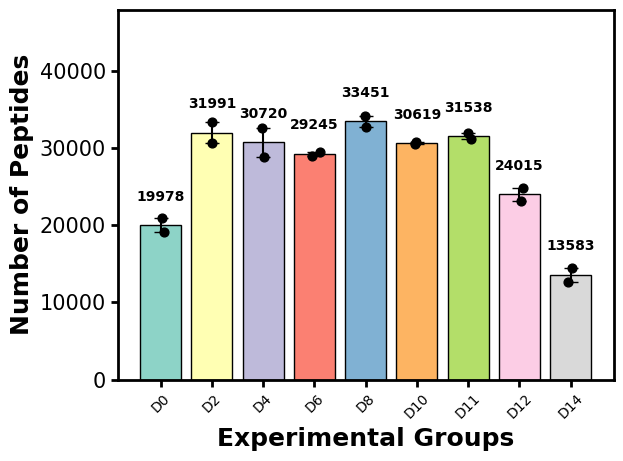

In [ ]:
#@title **Peptides: median values**

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/peptide_counts.csv'
df = pd.read_csv(file_path)

def update_dataframe(df):
    groups = df.groupby('Experimental groups')['Number of peptides'].apply(list).to_dict()
    medians = []
    std_devs = []
    all_values = []

    ordered_groups = {group: groups[group] for group in df['Experimental groups'].unique()}

    for group_name, values in ordered_groups.items():
        medians.append(np.median(values))
        std_devs.append(np.std(values))
        all_values.append(values)

    fig, ax = plt.subplots()
    colors = sns.color_palette('Set3', len(ordered_groups))
    bars = ax.bar(ordered_groups.keys(), medians, yerr=std_devs, capsize=5, color=colors, edgecolor='black')

    offset = max(std_devs) * 1.5

    for i, group in enumerate(ordered_groups.keys()):
        y = all_values[i]
        x = np.random.normal(i, 0.04, size=len(y))
        ax.scatter(x, y, edgecolor='black', facecolor='black', s=40, zorder=2)

    for bar, median in zip(bars, medians):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f'{median:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('Experimental Groups', fontsize=18, fontweight='bold')
    ax.set_ylabel('Number of Peptides', fontweight='bold', fontsize=18)
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=10)

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax.margins(y=0.4)

    plt.savefig('PLOTS/Number_peptides_median.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()
update_dataframe(df)



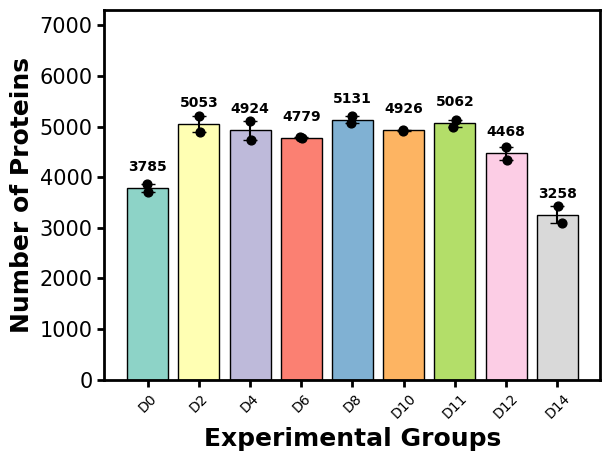

In [ ]:
#@title **Proteins: median values**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/protein_counts.csv'
df = pd.read_csv(file_path)

def update_dataframe(df):
    groups = df.groupby('Experimental groups')['Number of proteins'].apply(list).to_dict()
    medians = []
    std_devs = []
    all_values = []

    ordered_groups = {group: groups[group] for group in df['Experimental groups'].unique()}

    for group_name, values in ordered_groups.items():
        medians.append(np.median(values))
        std_devs.append(np.std(values))
        all_values.append(values)

    fig, ax = plt.subplots()
    colors = sns.color_palette('Set3', len(ordered_groups))
    bars = ax.bar(ordered_groups.keys(), medians, yerr=std_devs, capsize=5, color=colors, edgecolor='black')

    offset = max(std_devs) * 1.5

    for i, group in enumerate(ordered_groups.keys()):
        y = all_values[i]
        x = np.random.normal(i, 0.04, size=len(y))
        ax.scatter(x, y, edgecolor='black', facecolor='black', s=40, zorder=2)

    for bar, median in zip(bars, medians):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f'{median:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('Experimental Groups', fontsize=18, fontweight='bold')
    ax.set_ylabel('Number of Proteins', fontweight='bold', fontsize=18)
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=10)

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax.margins(y=0.4)

    plt.savefig('PLOTS/Number_proteins_median.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()
update_dataframe(df)



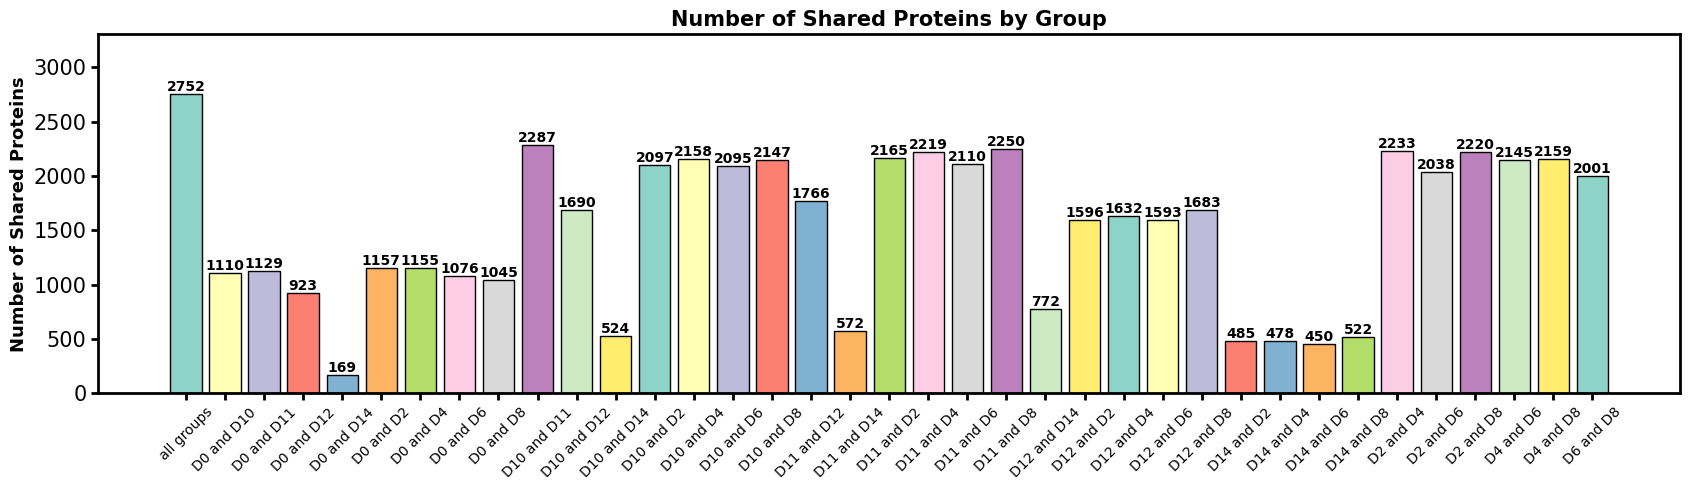

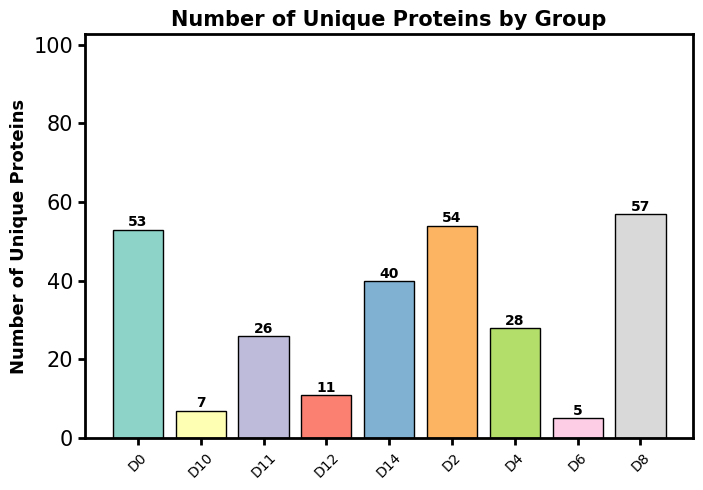

In [ ]:
#@title **Breackdown of shared and unique proteins**
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('TABLES/SHARED_UNIQUE_PROTEINS/shared_unique_proteins.csv')
shared_df = df[df['Group'].str.startswith('Shared by')].copy()
unique_df = df[df['Group'].str.startswith('Unique to')].copy()

shared_df.loc[:, 'Group'] = shared_df['Group'].str.replace('Shared by ', '', regex=False)
unique_df.loc[:, 'Group'] = unique_df['Group'].str.replace('Unique to ', '', regex=False)


plt.figure(figsize=(17, 5))
colors = sns.color_palette('Set3', len(shared_df['Group']))
bars = plt.bar(shared_df['Group'], shared_df['Number of Shared Proteins'], color=colors, edgecolor='black')
plt.ylabel('Number of Shared Proteins', fontweight='bold', fontsize=13)
plt.title('Number of Shared Proteins by Group', fontsize=15, fontweight='bold')
plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
plt.yticks(fontsize=15)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
ax1 = plt.gca()
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color("k")
ax1.margins(y=0.2)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.savefig('PLOTS/Shared_proteins.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 5))
colors = sns.color_palette('Set3', len(unique_df['Group']))
bars = plt.bar(unique_df['Group'], unique_df['Number of Unique Proteins'], color=colors, edgecolor='black')
plt.ylabel('Number of Unique Proteins', fontweight='bold', fontsize=13)
plt.title('Number of Unique Proteins by Group', fontsize=15, fontweight='bold')
plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
plt.yticks(fontsize=15)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
ax2 = plt.gca()
for spine in ax2.spines.values():
    spine.set_linewidth(2)
    spine.set_color("k")
ax2.margins(y=0.8)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.savefig('PLOTS/Unique_proteins.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

##**Number of peptides per protein**
- Plots a density plot for the number of peptides that were used to calculate the relative abundance of the overall proteome
- Plot the number of peptides for a given protein of interest

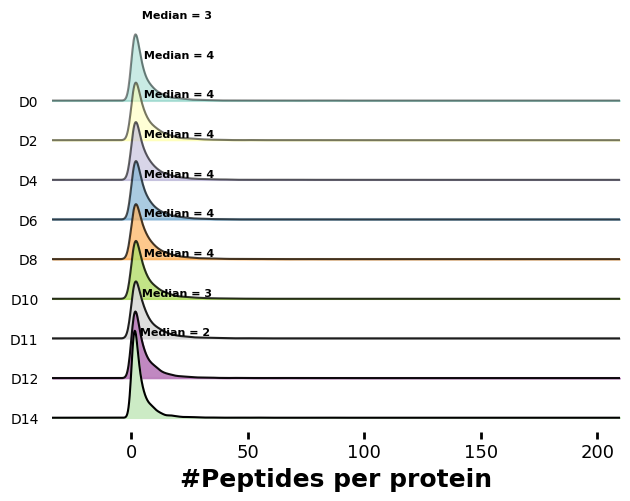

In [ ]:
#@title **Density plot**
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joypy
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['font.family'] = 'DejaVu Sans'
file_path = 'TABLES/melted_number_peptides_per_protein_per_group.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['Genes'])

def plot_data(df):
    group_names = [col for col in df.columns if col not in ['Protein name', 'Protein IDs']]

    melted_df = df.melt(id_vars=['Protein name', 'Protein IDs'], value_vars=group_names, var_name='Group', value_name='Value')
    melted_df['Group'] = pd.Categorical(melted_df['Group'], categories=group_names, ordered=True)
    melted_df = melted_df.sort_values('Group')

    fig, axes = joypy.joyplot(data=melted_df, by='Group', column='Value', colormap=plt.get_cmap('Set3'), fade=True)

    plt.xlabel('#Peptides per protein', fontsize=18, fontweight='bold')
    plt.ylabel('Density', fontsize=18, fontweight='bold')
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=15, fontweight='bold')

    for ax, group in zip(axes, group_names):
        median_value = int(df[group].median())
        ax.text(median_value, ax.get_ylim()[1] * 0.9, f' Median = {median_value}', color='black', fontsize=8, fontweight='bold')

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    plt.savefig('PLOTS/Density_peptides_per_protein.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

plot_data(df)

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein name', 'Genes'), style=Descr…

Text(value='', description='Name:', layout=Layout(width='auto'), placeholder='e.g., ACL6A_HUMAN or ACTL6A', st…

Button(description='Generate Plot', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_color…

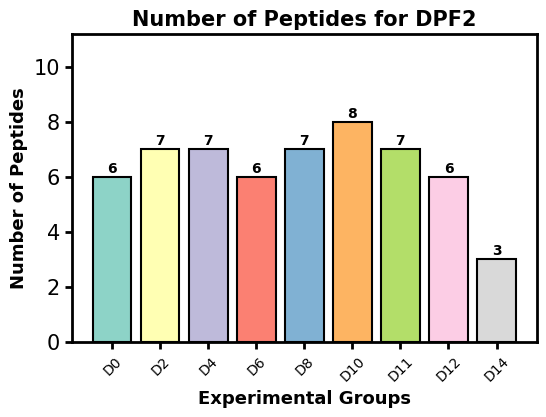

In [ ]:
#@title **Number of peptides for a given protein**
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

df = pd.read_csv('TABLES/melted_number_peptides_per_protein_per_group.csv')
def plot_protein_or_gene(name, search_by='Protein name'):
    if search_by == 'Protein name':
        data = df[df['Protein name'] == name]
    elif search_by == 'Genes':
        data = df[df['Genes'] == name]
    else:
        print(f"Invalid search criteria: {search_by}")
        return

    if data.empty:
        print(f"No data found for {search_by}: {name}")
        return

    all_groups = df.columns[3:]
    all_groups_df = pd.DataFrame(columns=all_groups)
    all_groups_df.loc[0] = 0
    data = pd.concat([all_groups_df, data], ignore_index=True).fillna(0)
    values = data.iloc[1].reindex(all_groups, fill_value=0)

    colors = sns.color_palette("Set3", len(all_groups))

    plt.figure(figsize=(6, 4))
    bars = plt.bar(all_groups, values, edgecolor='black', color=colors, linewidth=1.5)
    plt.xlabel('Experimental Groups', fontsize=13, fontweight='bold')
    plt.ylabel('Number of Peptides', fontsize=13, fontweight='bold')
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.title(f'Number of Peptides for {name}', fontweight='bold', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=10)

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        if pd.isna(yval) or yval == 0:
            plt.text(bar.get_x() + bar.get_width() / 2, 0.1, 'n.d.', ha='center', va='bottom', fontsize=15, color='red', fontweight='bold')
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax1.margins(y=0.4)
    plt.savefig(f'PLOTS/Number_peptides_for_{name}.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

search_by_dropdown = widgets.Dropdown(
    options=['Protein name', 'Genes'],
    value='Protein name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

name_input = widgets.Text(
    value='',
    placeholder='e.g., ACL6A_HUMAN or ACTL6A',
    description='Name:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(
    description="Generate Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def on_button_click(b):
    name = name_input.value
    search_by = search_by_dropdown.value
    plot_protein_or_gene(name, search_by)

button.on_click(on_button_click)

display(search_by_dropdown)
display(name_input)
display(button)

##**Exploratory Analysis**

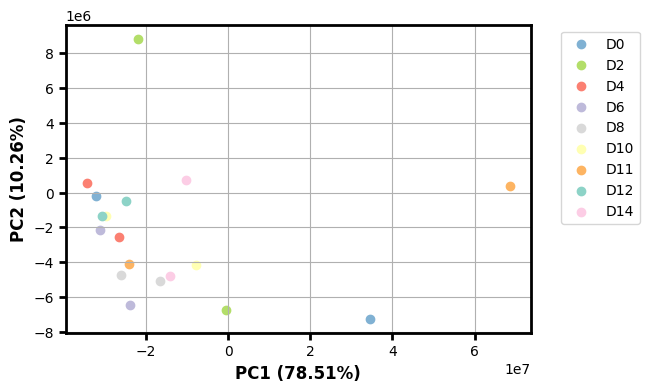

In [ ]:
#@title **Principal components analysis (PCA)**
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns

df = pd.read_csv('TABLES/Quantitative_parameters.csv')
pivot_df = df.pivot_table(index=['Protein name', 'Protein IDs', 'Genes'],
                          columns=['Experimental groups', 'Sample'],
                          values='Genes.MaxLFQ.Unique',
                          aggfunc='first',
                          sort=False)
pivot_df.columns = [f'{col[0]}' for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)

data_values = pivot_df.iloc[:, 3:]
imputer = SimpleImputer(strategy='mean')
data_values_imputed = imputer.fit_transform(data_values)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_values_imputed)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))
sample_names = pivot_df.columns[3:]
unique_sample_names = list(set(sample_names))
palette = sns.color_palette("Set3", len(unique_sample_names))

for i, sample in enumerate(sample_names):
    unique_sample_index = unique_sample_names.index(sample)
    plt.scatter(pca_df['PC1'][i], pca_df['PC2'][i], label=sample if sample not in plt.gca().get_legend_handles_labels()[1] else "", color=palette[unique_sample_index])

plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}%)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}%)', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

ax = plt.gca()
ax.grid(False)
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color("k")

plt.grid(True)
plt.savefig(f'PLOTS/PCA.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

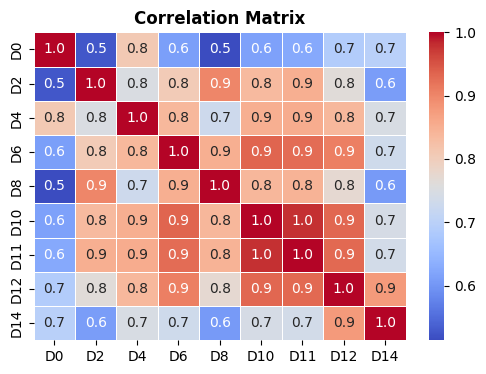

In [ ]:
#@title **Correlation Matrix**
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)
data_values = data.iloc[:, 3:]
imputer = SimpleImputer(strategy='mean')
data_values_imputed = imputer.fit_transform(data_values)
correlation_matrix = pd.DataFrame(data_values_imputed, columns=data.columns[3:]).corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Matrix',fontsize=12, fontweight='bold')
plt.savefig(f'PLOTS/Correlation_Matrix.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

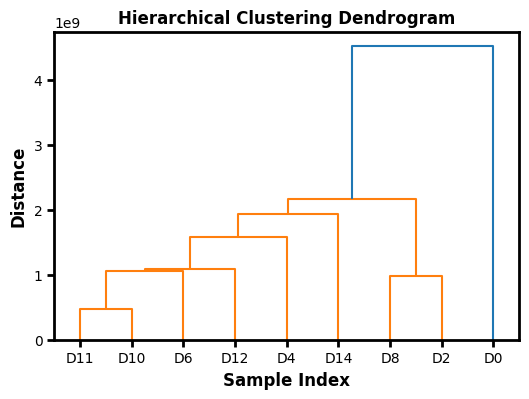

In [ ]:
#@title **Hierarchical Clustering Dendrogram**
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage

file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)
data_values = data.iloc[:, 3:]
imputer = SimpleImputer(strategy='mean')
data_values_imputed = imputer.fit_transform(data_values)
linked = linkage(data_values_imputed.T, method='ward')
plt.figure(figsize=(6, 4))
dendrogram(linked,
           orientation='top',
           labels=data.columns[3:],
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram',fontsize=12, fontweight='bold')
plt.xlabel('Sample Index',fontsize=12, fontweight='bold')
plt.ylabel('Distance', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

ax = plt.gca()
ax.grid(False)
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color("k")
plt.savefig(f'PLOTS/Hierarchical_Clustering_Dendrogram.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

##**Protein Ranking**

Dropdown(description='Experimental Groups:', options=('D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D11', 'D12', 'D14'…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

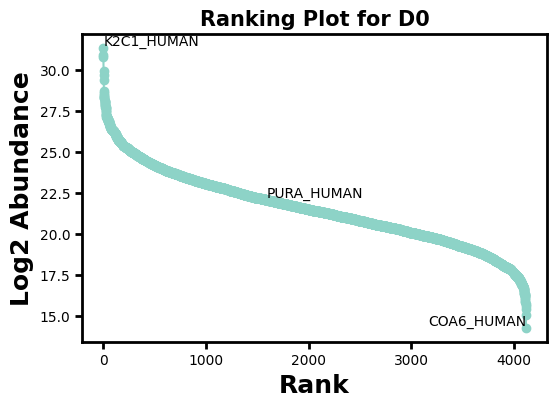

Ranking report was saved as: TABLES/Protein_Ranking_D0.csv


In [ ]:
#@title **Select experimental group**
#@markdown - Proteins are ranked based on their relative protein abundances
#@markdown - Names of the proteins with highest, medium, and lowest abundances are depicted in the plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'
data = pd.read_csv('TABLES/median_abundance.csv', delimiter=',')

data_melted = data.melt(id_vars=['Protein name', 'Protein IDs'], var_name='Experimental groups', value_name='Median Abundance')
data_melted['Median Abundance'] = pd.to_numeric(data_melted['Median Abundance'], errors='coerce')
data_melted = data_melted.dropna(subset=['Median Abundance'])

group_dropdown = widgets.Dropdown(
    options=data_melted['Experimental groups'].unique().tolist(),
    description='Experimental Groups:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)

def plot_data(group):
    filtered_data = data_melted[data_melted['Experimental groups'] == group].copy()

    filtered_data.loc[:, 'Log2 Abundance'] = np.log2(filtered_data['Median Abundance'])
    filtered_data = filtered_data.sort_values(by='Log2 Abundance', ascending=False)
    filtered_data.loc[:, 'Rank'] = range(1, len(filtered_data) + 1)

    colors = sns.color_palette("Set3", len(filtered_data))

    plt.figure(figsize=(6, 4))
    plt.plot(filtered_data['Rank'], filtered_data['Log2 Abundance'], marker='o', color=colors[0])

    plt.annotate(filtered_data.iloc[0]['Protein name'],
                 (filtered_data.iloc[0]['Rank'], filtered_data.iloc[0]['Log2 Abundance']),
                 textcoords="offset points", xytext=(0,2), ha='left')

    middle_index = len(filtered_data) // 2
    plt.annotate(filtered_data.iloc[middle_index]['Protein name'],
                 (filtered_data.iloc[middle_index]['Rank'], filtered_data.iloc[middle_index]['Log2 Abundance']),
                 textcoords="offset points", xytext=(0,10), ha='center')

    plt.annotate(filtered_data.iloc[-1]['Protein name'],
                 (filtered_data.iloc[-1]['Rank'], filtered_data.iloc[-1]['Log2 Abundance']),
                 textcoords="offset points", xytext=(0,2), ha='right')

    plt.xlabel('Rank', fontweight='bold', fontsize=18)
    plt.ylabel('Log2 Abundance', fontweight='bold', fontsize=18)
    plt.title(f'Ranking Plot for {group}', fontweight='bold', fontsize=15)
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    ax = plt.gca()
    ax.grid(False)

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    plt.savefig(f'PLOTS/Protein_ranking_plot_{group}.tiff', format='tiff', dpi=300)
    plt.show()

    all_proteins_ranked = filtered_data[['Protein name', 'Protein IDs', 'Experimental groups', 'Median Abundance', 'Log2 Abundance', 'Rank']]
    all_proteins_ranked.to_csv(f'TABLES/Protein_Ranking_{group}.csv', index=False, sep=',')

    print(f"Ranking report was saved as: TABLES/Protein_Ranking_{group}.csv")

def on_button_click(b):
    plot_data(group_dropdown.value)

plot_button.on_click(on_button_click)
display(group_dropdown, plot_button)

##**Comparison of proteome abundances among selected groups**

Dropdown(description='Group 1:', options=('D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D11', 'D12', 'D14'), style=Des…

Dropdown(description='Group 2:', options=('D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D11', 'D12', 'D14'), style=Des…

Dropdown(description='P-value threshold:', options=(0.05, 0.01, 0.005, 0.001), style=DescriptionStyle(descript…

Dropdown(description='FC threshold (±):', options=(0.5, 1, 1.5, 2), style=DescriptionStyle(description_width='…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

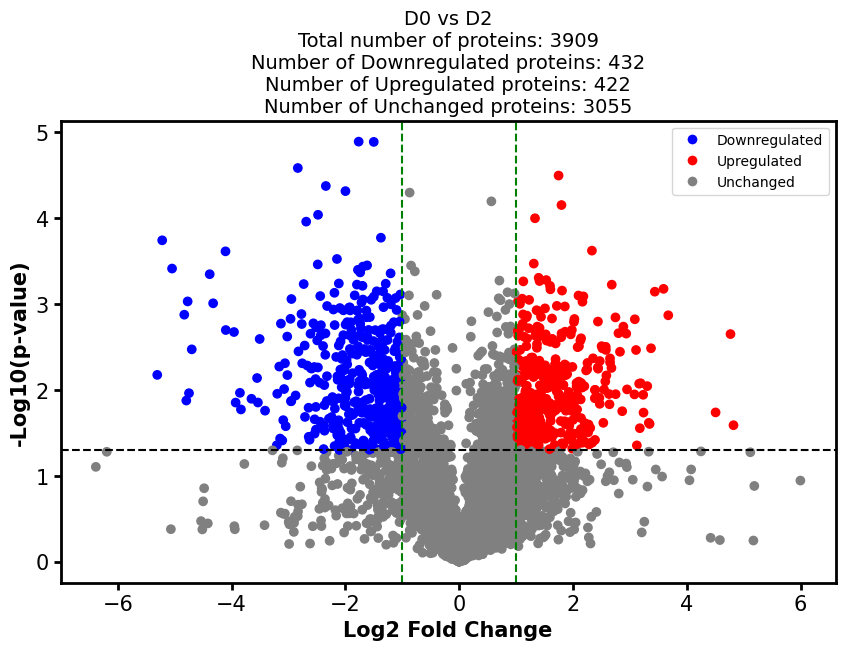

Report was saved as: TABLES/VOLCANO_PLOT_VALUES/D0 vs D2_Total_proteins.csv
Report was saved as: TABLES/VOLCANO_PLOT_VALUES/D0 vs D2_Downregulated.csv
Report was saved as: TABLES/VOLCANO_PLOT_VALUES/D0 vs D2_Upregulated.csv


In [ ]:
#@title **Volcano plot**
#@markdown - Select the two experimental groups that you need to compare
#@markdown - In some cases, this process may take between 1-2 minutes. Please be patient
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import warnings
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
output_dir = 'TABLES/VOLCANO_PLOT_VALUES'
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv('TABLES/Quantitative_parameters.csv')
unique_groups = df['Experimental groups'].unique()

group1_dropdown = widgets.Dropdown(
    options=unique_groups,
    description='Group 1:',
    style={'description_width': 'initial'}
)
group2_dropdown = widgets.Dropdown(
    options=unique_groups,
    description='Group 2:',
    style={'description_width': 'initial'}
)
p_value_threshold_dropdown = widgets.Dropdown(
    options=[0.05, 0.01, 0.005, 0.001],
    description='P-value threshold:',
    style={'description_width': 'initial'}
)
fc_threshold_dropdown = widgets.Dropdown(
    options=[0.5, 1, 1.5, 2],
    description='FC threshold (±):',
    style={'description_width': 'initial'}
)
plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)

def display_plot(b):
    group1 = group1_dropdown.value
    group2 = group2_dropdown.value
    p_value_threshold = p_value_threshold_dropdown.value
    fc_threshold = fc_threshold_dropdown.value

    group1_data = df[df['Experimental groups'] == group1]
    group2_data = df[df['Experimental groups'] == group2]

    proteins = df['Protein name'].unique()

    log2_fold_changes = []
    p_values = []
    valid_proteins = []
    valid_protein_ids = []
    valid_genes = []
    differential_expression_analysis = []

    upregulated_count = 0
    downregulated_count = 0
    unchanged_count = 0

    for protein in proteins:
        group1_values = group1_data[group1_data['Protein name'] == protein]['Genes.MaxLFQ.Unique'].dropna()
        group2_values = group2_data[group2_data['Protein name'] == protein]['Genes.MaxLFQ.Unique'].dropna()

        group1_values = group1_values[group1_values > 0]
        group2_values = group2_values[group2_values > 0]

        if len(group1_values) > 0 and len(group2_values) > 0:
            t_stat, p_val = ttest_ind(group1_values, group2_values)
            g1_mean = group1_values.mean()
            g2_mean = group2_values.mean()

            log2_fold_changes.append(np.log2(g2_mean / g1_mean))
            p_values.append(p_val)
            valid_proteins.append(protein)
            valid_protein_ids.append(df[df['Protein name'] == protein]['Protein IDs'].values[0])
            valid_genes.append(df[df['Protein name'] == protein]['Genes'].values[0])

            fc = np.log2(g2_mean / g1_mean)
            if (fc < -fc_threshold or fc > fc_threshold) and p_val <= p_value_threshold:
                if fc < 0:
                    downregulated_count += 1
                    differential_expression_analysis.append('Downregulated')
                else:
                    upregulated_count += 1
                    differential_expression_analysis.append('Upregulated')
            else:
                unchanged_count += 1
                differential_expression_analysis.append('Unchanged')

    volcano_data = pd.DataFrame({
        'Comparison': [f'{group1} vs {group2}'] * len(valid_proteins),
        'Protein name': valid_proteins,
        'Protein IDs': valid_protein_ids,
        'Genes': valid_genes,
        '-Log10(P-value)': -np.log10(p_values),
        'Log2 Fold Change': log2_fold_changes,
        'Differential expression analysis': differential_expression_analysis
    })

    volcano_data.dropna(inplace=True)

    downregulated_data = volcano_data[volcano_data['Differential expression analysis'] == 'Downregulated']
    upregulated_data = volcano_data[volcano_data['Differential expression analysis'] == 'Upregulated']

    downregulated_data.to_csv(f'TABLES/VOLCANO_PLOT_VALUES/{group1} vs {group2}_Downregulated.csv', index=False)
    upregulated_data.to_csv(f'TABLES/VOLCANO_PLOT_VALUES/{group1} vs {group2}_Upregulated.csv', index=False)

    total_proteins_count = len(valid_proteins)

    if not volcano_data.empty:
        plt.figure(figsize=(10, 6))
        colors = ['red' if x == 'Upregulated' else 'blue' if x == 'Downregulated' else 'gray' for x in volcano_data['Differential expression analysis']]
        plt.scatter(volcano_data['Log2 Fold Change'], volcano_data['-Log10(P-value)'], c=colors)

        plt.xlabel('Log2 Fold Change', fontweight='bold', fontsize=15)
        plt.ylabel('-Log10(p-value)', fontweight='bold', fontsize=15)
        plt.title(f'{group1} vs {group2}\nTotal number of proteins: {total_proteins_count}\nNumber of Downregulated proteins: {downregulated_count}\nNumber of Upregulated proteins: {upregulated_count}\nNumber of Unchanged proteins: {unchanged_count}', fontsize=14)

        plt.axhline(y=-np.log10(p_value_threshold), color='black', linestyle='--', label=f'p-value threshold ({p_value_threshold})')
        plt.axvline(x=fc_threshold, color='green', linestyle='--', label=f'Fold change threshold (±{fc_threshold})')
        plt.axvline(x=-fc_threshold, color='green', linestyle='--')

        plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
        plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

        ax1 = plt.gca()
        for spine in ax1.spines.values():
            spine.set_linewidth(2)
            spine.set_color("k")

        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Downregulated'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Upregulated'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Unchanged')
        ]

        plt.legend(handles=legend_elements)

        plt.savefig(f'PLOTS/{group1} vs {group2}_volcano_plot.tiff', format='tiff', dpi=300, bbox_inches='tight')
        plt.show()

    volcano_data.to_csv(f'TABLES/VOLCANO_PLOT_VALUES/{group1} vs {group2}_Total_proteins.csv', index=False)
    print(f"Report was saved as: TABLES/VOLCANO_PLOT_VALUES/{group1} vs {group2}_Total_proteins.csv")
    print(f"Report was saved as: TABLES/VOLCANO_PLOT_VALUES/{group1} vs {group2}_Downregulated.csv")
    print(f"Report was saved as: TABLES/VOLCANO_PLOT_VALUES/{group1} vs {group2}_Upregulated.csv")

plot_button.on_click(display_plot)
display(group1_dropdown, group2_dropdown, p_value_threshold_dropdown, fc_threshold_dropdown, plot_button)

##**Abundance of a specific protein**

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein name', 'Genes'), style=Descr…

Text(value='', description='Name:', layout=Layout(width='auto'), placeholder='e.g., ACL6A_HUMAN or ACTL6A', st…

Button(description='Generate Plot', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_color…

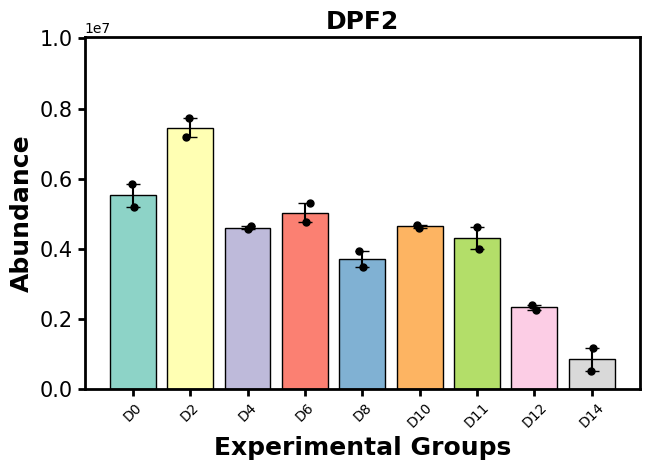

In [ ]:
#@title **Bar plot with no stats**
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import compactletterdisplay
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

search_criteria = widgets.Dropdown(
    options=['Protein name', 'Genes'],
    value='Protein name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

group_names_input = widgets.Text(
    value='',
    placeholder='e.g., ACL6A_HUMAN or ACTL6A',
    description='Name:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(
    description="Generate Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def update_dataframe(name, search_by):
    file_path = 'TABLES/Quantitative_parameters.csv'
    df = pd.read_csv(file_path)

    if search_by == 'Protein name':
        df_filtered = df[df['Protein name'].str.contains(name, case=False, na=False)]
    elif search_by == 'Genes':
        df_filtered = df[df['Genes'].str.contains(name, case=False, na=False)]
    else:
        print(f"Invalid search criteria: {search_by}")
        return

    if df_filtered.empty:
        print(f"No data found for {search_by}: {name}")
        return

    df_filtered = df_filtered.drop_duplicates(subset=['Genes.MaxLFQ.Unique'])
    groups = df_filtered.groupby('Experimental groups')['Genes.MaxLFQ.Unique'].apply(list).to_dict()

    medians = []
    std_devs = []
    all_values = []

    all_groups = df['Experimental groups'].unique().tolist()

    for group_name in all_groups:
        values = groups.get(group_name, [])
        if len(values) > 0:
            medians.append(np.median(values))
            std_devs.append(np.std(values))
            all_values.append(values)
        else:
            medians.append(0)
            std_devs.append(0)
            all_values.append([])

    fig, ax = plt.subplots()
    colors = sns.color_palette('Set3', len(all_groups))

    bars = ax.bar(all_groups, medians, yerr=std_devs, capsize=5, color=colors, edgecolor='black')

    for i, group in enumerate(all_groups):
        if len(all_values[i]) == 0:
            ax.text(i, 0.5, 'n.d.', ha='center', va='bottom', fontsize=15, color='red', fontweight='bold')

    for i, group in enumerate(all_groups):
        if len(all_values[i]) > 0:
            y_values = all_values[i]
            x_values = np.random.normal(i, 0.04, size=len(y_values))
            ax.plot(x_values, y_values, 'ko', markersize=5)

    ax.set_title(f'{name}', fontweight='bold', fontsize=18)
    plt.xlabel('Experimental Groups', fontsize=18, fontweight='bold')
    ax.set_ylabel('Abundance', fontweight='bold', fontsize=18)
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax.margins(y=0.3)
    plt.savefig(f'PLOTS/Abundance_selected_protein_{name}.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

button.on_click(lambda b: update_dataframe(group_names_input.value, search_criteria.value))
display(search_criteria, group_names_input, button)

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein name', 'Genes'), style=Descr…

Text(value='', description='Name:', layout=Layout(width='auto'), placeholder='e.g., ACL6A_HUMAN or ACTL6A', st…

Dropdown(description='Reference group:', layout=Layout(width='auto'), options=('D0', 'D2', 'D4', 'D6', 'D8', '…

Button(description='Generate Plot', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_color…

Statistical analysis report was saved as: TABLES/paired_statistical_analysis_results_DPF2.csv


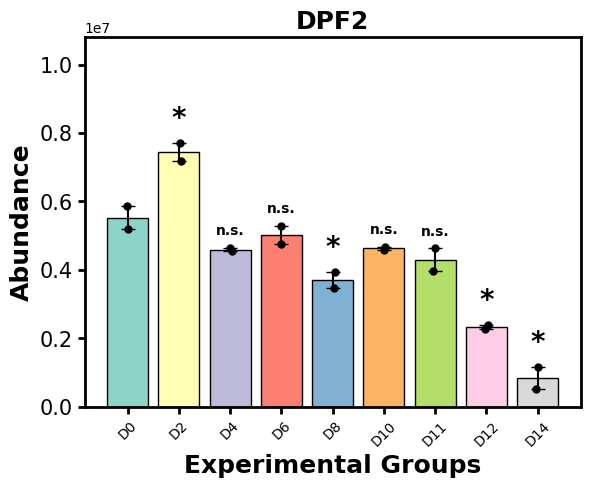

In [ ]:
#@title **Bar plot with t-test**
#@markdown - Data represent medians ± SD among replicates of a given experimental group
#@markdown - If there are no values for the protein in an experimental group, t-test will not be performed, but the plot will still be displayed. Experimental groups with no values will be depicted as "n.d." (not detected)
#@markdown - Statistical significant (P < 0.05) values are represented by "*" whereas no differences (P > 0.05) are depicted by "n.s."
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from scipy.stats import ttest_ind

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/Quantitative_parameters.csv'
df = pd.read_csv(file_path)


search_criteria = widgets.Dropdown(
    options=['Protein name', 'Genes'],
    value='Protein name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

group_names_input = widgets.Text(
    value='',
    placeholder='e.g., ACL6A_HUMAN or ACTL6A',
    description='Name:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

reference_group_input = widgets.Dropdown(
    options=[],
    description='Reference group:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(description="Generate Plot", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(
    width='auto',
    height='80px'
))

def update_reference_group_options():
    experimental_groups = df['Experimental groups'].unique().tolist()
    reference_group_input.options = experimental_groups

def update_dataframe(name, search_by, reference_group):
    if search_by == 'Protein name':
        df_filtered = df[df['Protein name'].str.contains(name, case=False, na=False)]
    elif search_by == 'Genes':
        df_filtered = df[df['Genes'].str.contains(name, case=False, na=False)]
    else:
        print(f"Invalid search criteria: {search_by}")
        return

    df_filtered = df_filtered.drop_duplicates(subset=['Genes.MaxLFQ.Unique'])
    groups = df_filtered.groupby('Experimental groups')['Genes.MaxLFQ.Unique'].apply(list).to_dict()

    medians = []
    std_devs = []
    all_values = []

    all_groups = reference_group_input.options

    for group_name in all_groups:
        values = groups.get(group_name, [])
        if len(values) > 0:
            medians.append(np.median(values))
            std_devs.append(np.std(values))
            all_values.append(values)
        else:
            medians.append(0)
            std_devs.append(0)
            all_values.append([])

    fig, ax = plt.subplots()
    colors = sns.color_palette('Set3', len(all_groups))

    bars = ax.bar(all_groups, medians, yerr=std_devs, capsize=5, color=colors, edgecolor='black')

    for i, group in enumerate(all_groups):
        if len(all_values[i]) == 0:
            ax.text(i, 0.5, 'n.d.', ha='center', va='bottom', fontsize=15, color='red', fontweight='bold')

    for i, group in enumerate(all_groups):
        if len(all_values[i]) > 0:
            y_values = all_values[i]
            x_values = np.random.normal(i, 0.04, size=len(y_values))
            ax.plot(x_values, y_values, 'ko', markersize=5)

    ax.set_title(f'{name}', fontweight='bold', fontsize=18)
    plt.xlabel('Experimental Groups', fontsize=18, fontweight='bold')
    ax.set_ylabel('Abundance', fontweight='bold', fontsize=18)
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=10)

    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")
    ax.margins(y=0.4)

    if len([g for g in all_groups if len(groups.get(g, [])) == 0]) == 0:
        p_values = []
        if reference_group in groups:
            for group in all_groups:
                if group != reference_group and len(groups[group]) > 0:
                    stat, p_value = ttest_ind(groups[reference_group], groups[group])
                    p_values.append(p_value)

        if p_values:
            offset = max(std_devs) * 0.9
            for i, group in enumerate(all_groups):
                if group != reference_group and len(groups[group]) > 0:
                    y_pos = medians[i] + std_devs[i] + offset
                    if p_values[i-1] <= 0.05:  # Use raw p-values and check for <= 0.05
                        ax.text(i, y_pos, '*', ha='center', va='bottom', fontsize=20, color='black', fontweight='bold')
                    else:
                        ax.text(i, y_pos, 'n.s.', ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

            comparisons = [f"{reference_group} vs {group}" for group in all_groups if group != reference_group and len(groups[group]) > 0]
            significant = ["YES" if p <= 0.05 else "NO" for p in p_values]

            result_df = pd.DataFrame({
                'Protein Name': [name] * len(comparisons),
                'Comparison': comparisons,
                'Raw P-Value': p_values,
                'Significant': significant
            })

            result_df.to_csv(f'TABLES/paired_statistical_analysis_results_{name}.csv', index=False)
            print(f"Statistical analysis report was saved as: TABLES/paired_statistical_analysis_results_{name}.csv")

    plt.savefig(f'PLOTS/Abundance_selected_protein_reference_paired_comparisons_{name}.tiff', format='tiff', dpi=300, bbox_inches='tight')

update_reference_group_options()
display(search_criteria, group_names_input, reference_group_input, button)
button.on_click(lambda x: update_dataframe(group_names_input.value, search_criteria.value, reference_group_input.value))


## Functional Enrichment Analysis

### Kyoto Encyclopedia of Genes and Genomes (KEGG)

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Dropdown(description='Experimental Groups:', options=('D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D11', 'D12', 'D14'…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

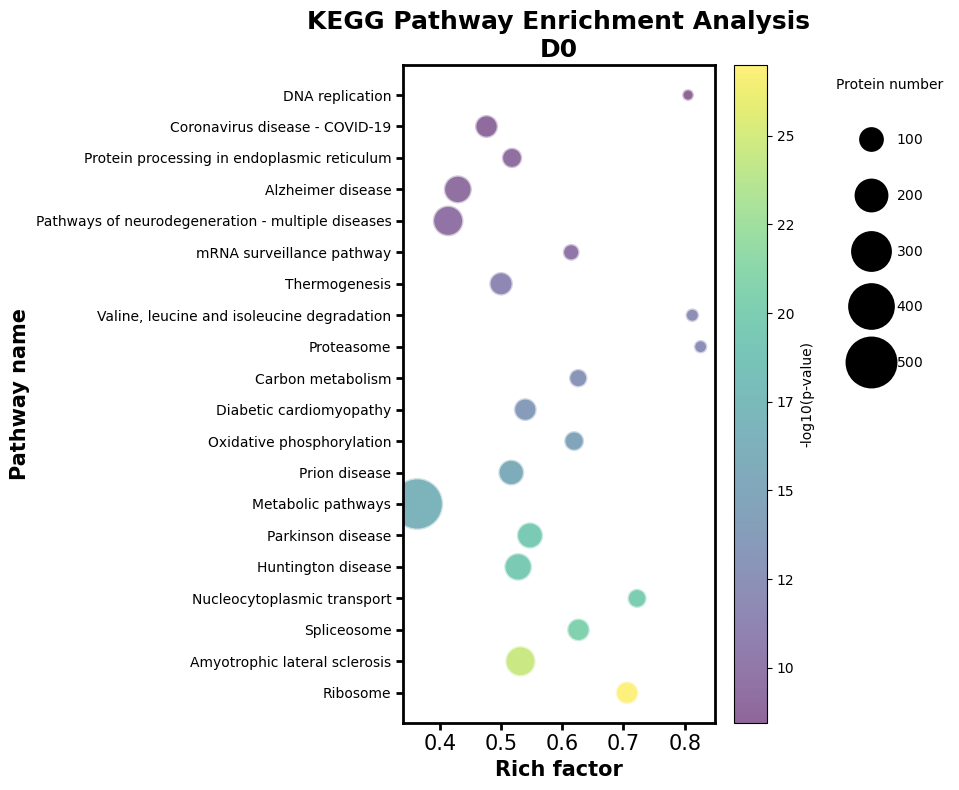

In [ ]:
#@title **KEGG plots for a given experimental group**

import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'
data = pd.read_csv('TABLES/Quantitative_parameters.csv', sep=',')
unique_genes = data['Genes'].unique().tolist()
gp = GProfiler(return_dataframe=True)

def perform_kegg_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['KEGG'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def plot_kegg_results(results, filename, group_name):
    kegg_results = results[results['source'] == 'KEGG']
    kegg_results['rich_factor'] = kegg_results['intersection_size'] / kegg_results['term_size']
    kegg_results = kegg_results.nsmallest(20, 'p_value')

    if not kegg_results.empty:
        plt.figure(figsize=(10, 8))
        bubble = plt.scatter(
            kegg_results['rich_factor'],
            kegg_results['name'],
            s=kegg_results['intersection_size'] * 2.5,
            c=-np.log10(kegg_results['p_value']),
            cmap='viridis',
            alpha=0.6,
            edgecolors="w",
            linewidth=2
        )

        cbar = plt.colorbar(bubble, label='-log10(p-value)')
        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

        plt.xlabel('Rich factor', fontweight='bold', fontsize=15)
        plt.ylabel('Pathway name', fontweight='bold', fontsize=15)
        plt.title(f'KEGG Pathway Enrichment Analysis\n{group_name}', fontweight='bold', fontsize=18)
        plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
        plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
        plt.xticks(fontsize=15)
        plt.grid(False)
        ax1 = plt.gca()
        for spine in ax1.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        handles, labels = bubble.legend_elements(prop="sizes", alpha=1, num=6, func=lambda s: s / 2.5)
        legend2 = plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.35, 1), title="Protein number", markerscale=1, labelspacing=3, frameon=False)
        plt.tight_layout()
        plt.savefig(f'PLOTS/{filename}_{group_name}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print("No significant KEGG results to plot.")

group_dropdown = widgets.Dropdown(
    options=data['Experimental groups'].unique().tolist(),
    description='Experimental Groups:',
    style={'description_width': 'initial'}
)

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)

def on_button_click(b):
    selected_group = group_dropdown.value
    group_genes = data[data['Experimental groups'] == selected_group]['Genes'].unique().tolist()

    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    selected_organism = organism_dropdown.value
    significant_results = perform_kegg_analysis(group_genes, selected_organism)
    plot_kegg_results(significant_results, 'KEGG_enrichment', selected_group)

plot_button.on_click(on_button_click)
display(organism_dropdown, group_dropdown, plot_button)


Dropdown(description='Select File:', options=('D0 vs D2_Total_proteins.csv',), style=DescriptionStyle(descript…

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

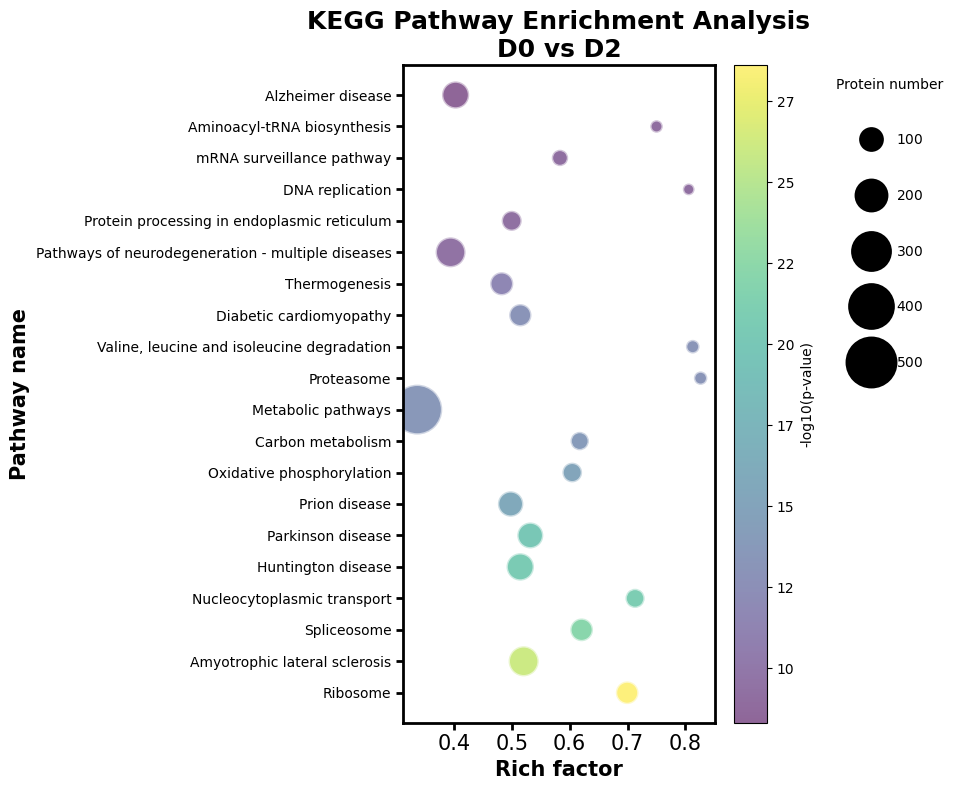

In [ ]:
#@title **KEGG plots for all proteins from a given experimental group comparison**
import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import os

plt.rcParams['font.family'] = 'DejaVu Sans'
gp = GProfiler(return_dataframe=True)

def perform_kegg_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['KEGG'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def plot_kegg_results(results, filename, comparison_name):
    kegg_results = results[results['source'] == 'KEGG']
    kegg_results['rich_factor'] = kegg_results['intersection_size'] / kegg_results['term_size']
    kegg_results = kegg_results.nsmallest(20, 'p_value')

    if not kegg_results.empty:
        plt.figure(figsize=(10, 8))
        bubble = plt.scatter(
            kegg_results['rich_factor'],
            kegg_results['name'],
            s=kegg_results['intersection_size'] * 2.5,
            c=-np.log10(kegg_results['p_value']),
            cmap='viridis',
            alpha=0.6,
            edgecolors="w",
            linewidth=2
        )

        cbar = plt.colorbar(bubble, label='-log10(p-value)')
        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

        plt.xlabel('Rich factor', fontweight='bold', fontsize=15)
        plt.ylabel('Pathway name', fontweight='bold', fontsize=15)
        plt.title(f'KEGG Pathway Enrichment Analysis\n{comparison_name}', fontweight='bold', fontsize=18)
        plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
        plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
        plt.xticks(fontsize=15)
        plt.grid(False)
        ax1 = plt.gca()
        for spine in ax1.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        handles, labels = bubble.legend_elements(prop="sizes", alpha=1, num=6, func=lambda s: s / 2.5)
        legend2 = plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.35, 1), title="Protein number", markerscale=1, labelspacing=3, frameon=False)
        plt.tight_layout()
        plt.savefig(f'PLOTS/{filename}_{comparison_name}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print("No significant KEGG results to plot.")

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

file_options = [f for f in os.listdir('TABLES/VOLCANO_PLOT_VALUES') if f.endswith('_Total_proteins.csv')]
file_dropdown = widgets.Dropdown(
    options=file_options,
    description='Select File:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)

def on_button_click(b):
    selected_file = file_dropdown.value
    data = pd.read_csv(f'TABLES/VOLCANO_PLOT_VALUES/{selected_file}', sep=',')

    comparison_name = data['Comparison'].iloc[0]
    group_genes = data['Genes'].unique().tolist()
    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    selected_organism = organism_dropdown.value
    significant_results = perform_kegg_analysis(group_genes, selected_organism)
    plot_kegg_results(significant_results, 'KEGG_enrichment', comparison_name)

plot_button.on_click(on_button_click)
display(file_dropdown, organism_dropdown, plot_button)

Dropdown(description='Select File:', options=('D0 vs D2_Upregulated.csv',), style=DescriptionStyle(description…

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

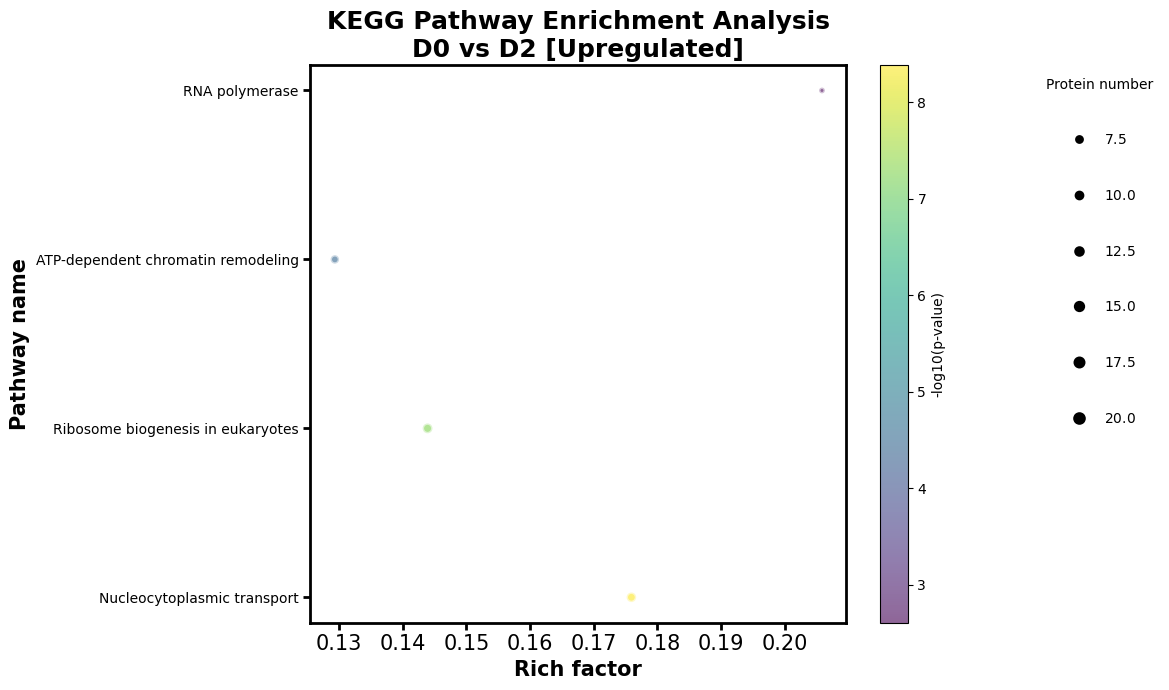

In [ ]:
#@title **KEGG plots for all proteins from a given experimental group comparison - Upregulated Proteins**
import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import os

plt.rcParams['font.family'] = 'DejaVu Sans'
gp = GProfiler(return_dataframe=True)

def perform_kegg_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['KEGG'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def plot_kegg_results(results, filename, comparison_name):
    kegg_results = results[results['source'] == 'KEGG']
    kegg_results['rich_factor'] = kegg_results['intersection_size'] / kegg_results['term_size']
    kegg_results = kegg_results.nsmallest(20, 'p_value')

    if not kegg_results.empty:
        plt.figure(figsize=(12, 7))
        bubble = plt.scatter(
            kegg_results['rich_factor'],
            kegg_results['name'],
            s=kegg_results['intersection_size'] * 2.5,
            c=-np.log10(kegg_results['p_value']),
            cmap='viridis',
            alpha=0.6,
            edgecolors="w",
            linewidth=2
        )

        cbar = plt.colorbar(bubble, label='-log10(p-value)')
        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

        plt.xlabel('Rich factor', fontweight='bold', fontsize=15)
        plt.ylabel('Pathway name', fontweight='bold', fontsize=15)
        plt.title(f'KEGG Pathway Enrichment Analysis\n{comparison_name} [Upregulated]', fontweight='bold', fontsize=18)
        plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
        plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
        plt.xticks(fontsize=15)
        plt.grid(False)
        ax1 = plt.gca()
        for spine in ax1.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        handles, labels = bubble.legend_elements(prop="sizes", alpha=1, num=6, func=lambda s: s / 2.5)
        legend2 = plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.35, 1), title="Protein number", markerscale=1, labelspacing=3, frameon=False)
        plt.tight_layout()
        plt.savefig(f'PLOTS/{filename}_{comparison_name}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print("No significant KEGG results to plot.")

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

file_options = [f for f in os.listdir('TABLES/VOLCANO_PLOT_VALUES') if f.endswith('_Upregulated.csv')]
file_dropdown = widgets.Dropdown(
    options=file_options,
    description='Select File:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)

def on_button_click(b):
    selected_file = file_dropdown.value
    data = pd.read_csv(f'TABLES/VOLCANO_PLOT_VALUES/{selected_file}', sep=',')

    comparison_name = data['Comparison'].iloc[0]
    group_genes = data['Genes'].unique().tolist()
    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    selected_organism = organism_dropdown.value
    significant_results = perform_kegg_analysis(group_genes, selected_organism)
    plot_kegg_results(significant_results, 'KEGG_enrichment', comparison_name)

plot_button.on_click(on_button_click)
display(file_dropdown, organism_dropdown, plot_button)

Dropdown(description='Select File:', options=('D0 vs D2_Downregulated.csv',), style=DescriptionStyle(descripti…

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

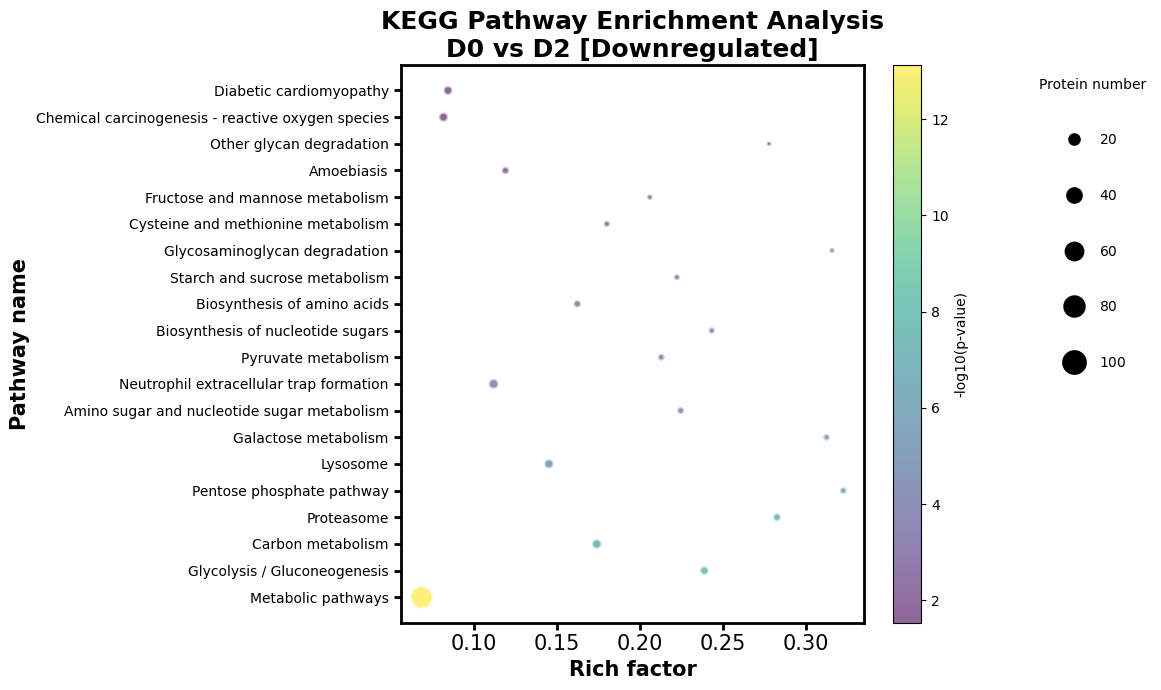

In [ ]:
#@title **KEGG plots for all proteins from a given experimental group comparison - Downregulated Proteins**
import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import os

plt.rcParams['font.family'] = 'DejaVu Sans'
gp = GProfiler(return_dataframe=True)

def perform_kegg_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['KEGG'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def plot_kegg_results(results, filename, comparison_name):
    kegg_results = results[results['source'] == 'KEGG']
    kegg_results['rich_factor'] = kegg_results['intersection_size'] / kegg_results['term_size']
    kegg_results = kegg_results.nsmallest(20, 'p_value')

    if not kegg_results.empty:
        plt.figure(figsize=(12, 7))
        bubble = plt.scatter(
            kegg_results['rich_factor'],
            kegg_results['name'],
            s=kegg_results['intersection_size'] * 2.5,
            c=-np.log10(kegg_results['p_value']),
            cmap='viridis',
            alpha=0.6,
            edgecolors="w",
            linewidth=2
        )

        cbar = plt.colorbar(bubble, label='-log10(p-value)')
        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

        plt.xlabel('Rich factor', fontweight='bold', fontsize=15)
        plt.ylabel('Pathway name', fontweight='bold', fontsize=15)
        plt.title(f'KEGG Pathway Enrichment Analysis\n{comparison_name} [Downregulated]', fontweight='bold', fontsize=18)
        plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
        plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
        plt.xticks(fontsize=15)
        plt.grid(False)
        ax1 = plt.gca()
        for spine in ax1.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        handles, labels = bubble.legend_elements(prop="sizes", alpha=1, num=6, func=lambda s: s / 2.5)
        legend2 = plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.35, 1), title="Protein number", markerscale=1, labelspacing=3, frameon=False)
        plt.tight_layout()
        plt.savefig(f'PLOTS/{filename}_{comparison_name}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print("No significant KEGG results to plot.")

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

file_options = [f for f in os.listdir('TABLES/VOLCANO_PLOT_VALUES') if f.endswith('_Downregulated.csv')]
file_dropdown = widgets.Dropdown(
    options=file_options,
    description='Select File:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)

def on_button_click(b):
    selected_file = file_dropdown.value
    data = pd.read_csv(f'TABLES/VOLCANO_PLOT_VALUES/{selected_file}', sep=',')

    comparison_name = data['Comparison'].iloc[0]
    group_genes = data['Genes'].unique().tolist()
    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    selected_organism = organism_dropdown.value
    significant_results = perform_kegg_analysis(group_genes, selected_organism)
    plot_kegg_results(significant_results, 'KEGG_enrichment', comparison_name)

plot_button.on_click(on_button_click)
display(file_dropdown, organism_dropdown, plot_button)

## Gene ontology (GO)

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Dropdown(description='Experimental Groups:', options=('D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D11', 'D12', 'D14'…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

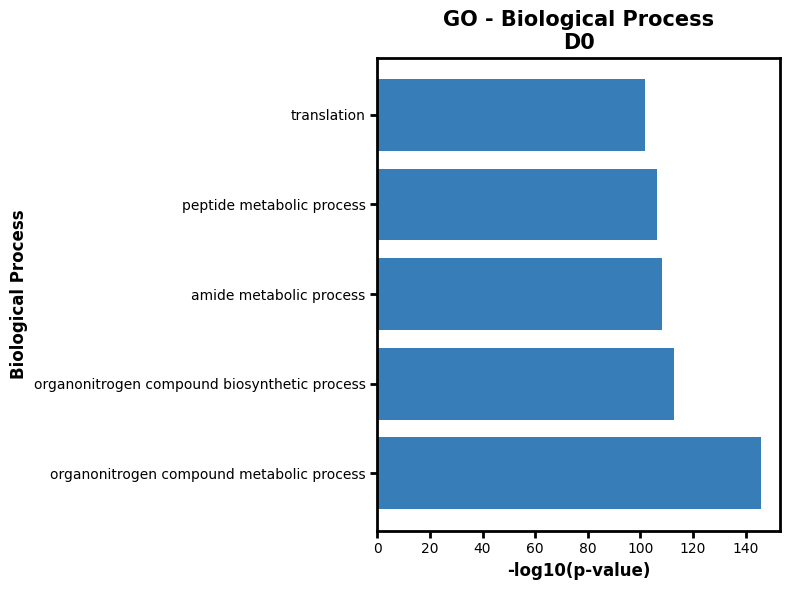

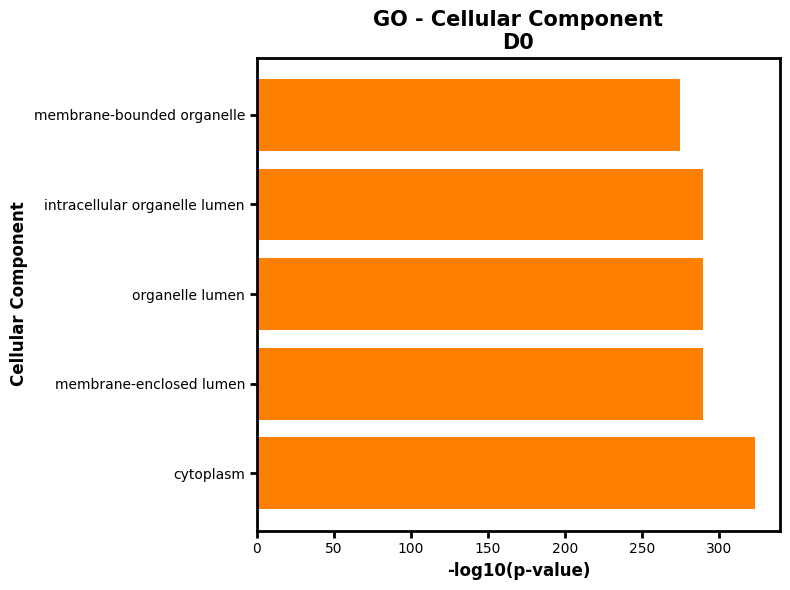

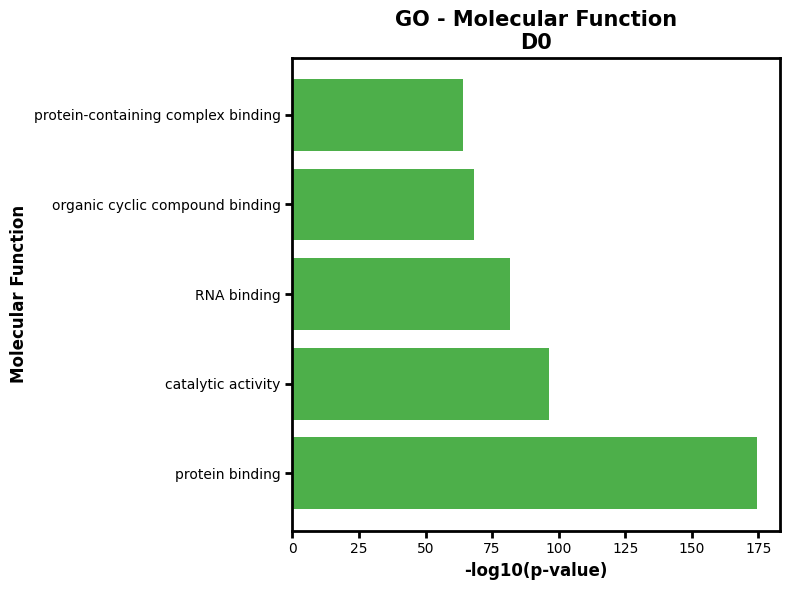

In [ ]:
#@title **GO plots for a given experimental group**
import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'

data = pd.read_csv('TABLES/Quantitative_parameters.csv')
unique_genes = data['Genes'].unique().tolist()

gp = GProfiler(return_dataframe=True)

def perform_go_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['GO:BP', 'GO:CC', 'GO:MF'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def customize_plot():
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(fontsize=10)
    plt.grid(False)
    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

def plot_go_results(results, source, color, ylabel, title, filename):
    if not results.empty:
        plt.figure(figsize=(8, 6))
        plt.barh(results['name'], -np.log10(results['p_value']), color=color)
        plt.xlabel('-log10(p-value)', fontweight='bold', fontsize=12)
        plt.ylabel(ylabel, fontweight='bold', fontsize=12)
        plt.title(title, fontweight='bold', fontsize=15)
        customize_plot()
        plt.tight_layout()
        plt.savefig(f'PLOTS/{filename}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print(f"No significant {ylabel} results to plot.")

group_dropdown = widgets.Dropdown(
    options=data['Experimental groups'].unique().tolist(),
    description='Experimental Groups:',
    style={'description_width': 'initial'}
)

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)

def on_button_click(b):
    selected_group = group_dropdown.value
    group_genes = data[data['Experimental groups'] == selected_group]['Genes'].unique().tolist()

    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    selected_organism = organism_dropdown.value
    significant_results = perform_go_analysis(group_genes, selected_organism)

    bp_results = significant_results[significant_results['source'] == 'GO:BP'].nsmallest(5, 'p_value')
    cc_results = significant_results[significant_results['source'] == 'GO:CC'].nsmallest(5, 'p_value')
    mf_results = significant_results[significant_results['source'] == 'GO:MF'].nsmallest(5, 'p_value')

    plot_go_results(bp_results, 'GO:BP', '#377eb8', 'Biological Process', f'GO - Biological Process\n{selected_group}', f'GO_BP_enrichment_{selected_group}')
    plot_go_results(cc_results, 'GO:CC', '#ff7f00', 'Cellular Component', f'GO - Cellular Component\n{selected_group}', f'GO_CC_enrichment_{selected_group}')
    plot_go_results(mf_results, 'GO:MF', '#4daf4a', 'Molecular Function', f'GO - Molecular Function\n{selected_group}', f'GO_MF_enrichment_{selected_group}')

plot_button.on_click(on_button_click)
display(organism_dropdown, group_dropdown, plot_button)



Dropdown(description='Select File:', options=('D0 vs D2_Total_proteins.csv',), style=DescriptionStyle(descript…

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

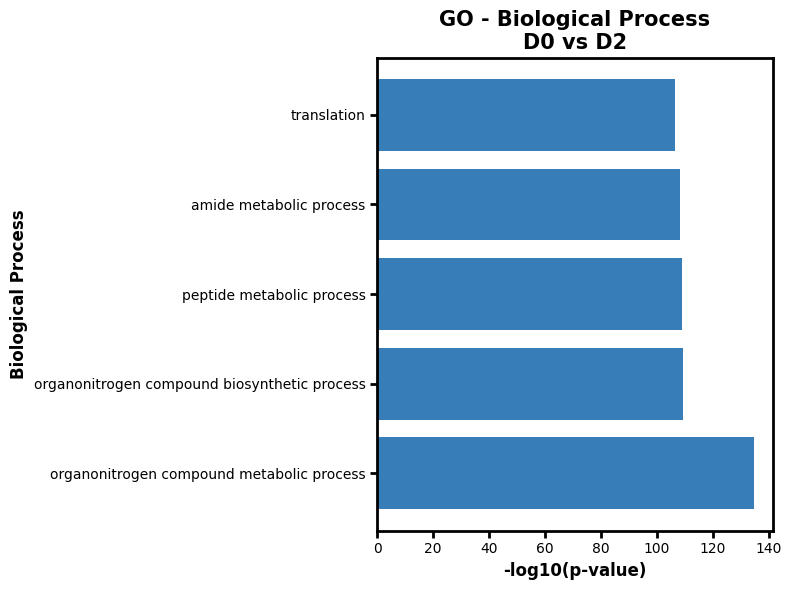

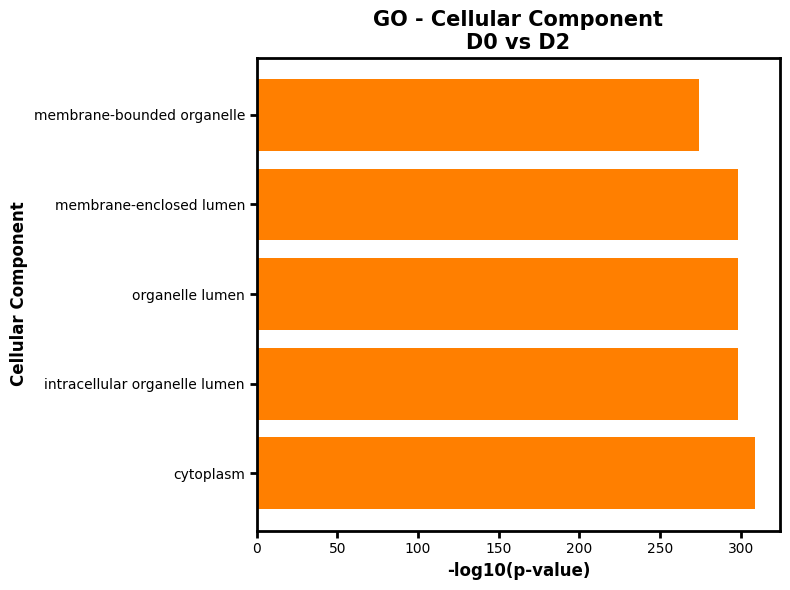

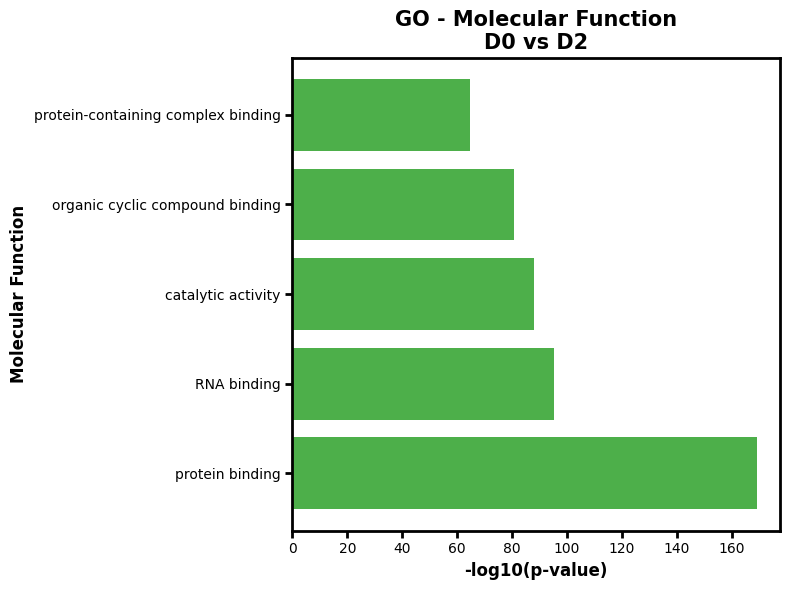

In [ ]:
#@title **GO plots for all proteins from a given experimental group comparison**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from gprofiler import GProfiler
import os


plt.rcParams['font.family'] = 'DejaVu Sans'
file_options = [f for f in os.listdir('TABLES/VOLCANO_PLOT_VALUES') if f.endswith('_Total_proteins.csv')]
file_dropdown = widgets.Dropdown(
    options=file_options,
    description='Select File:',
    style={'description_width': 'initial'}
)

gp = GProfiler(return_dataframe=True)

def perform_go_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['GO:BP', 'GO:CC', 'GO:MF'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def customize_plot():
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(fontsize=10)
    plt.grid(False)
    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

def plot_go_results(results, source, color, ylabel, title, comparison_name):
    if not results.empty:
        plt.figure(figsize=(8, 6))
        plt.barh(results['name'], -np.log10(results['p_value']), color=color)
        plt.xlabel('-log10(p-value)', fontweight='bold', fontsize=12)
        plt.ylabel(ylabel, fontweight='bold', fontsize=12)
        plt.title(f'{title}\n{comparison_name}', fontweight='bold', fontsize=15)
        customize_plot()
        plt.tight_layout()
        plt.savefig(f'PLOTS/{ylabel}_{comparison_name}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print(f"No significant {ylabel} results to plot.")

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)


def on_button_click(b):
    selected_file = file_dropdown.value
    data = pd.read_csv(f'TABLES/VOLCANO_PLOT_VALUES/{selected_file}', sep=',')

    comparison_name = data['Comparison'].iloc[0]

    group_genes = data['Genes'].unique().tolist()
    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    if not group_genes:
        print("No genes found in the selected file.")
        return

    selected_organism = organism_dropdown.value
    significant_results = perform_go_analysis(group_genes, selected_organism)

    if significant_results.empty:
        print("No significant results found.")
        return

    bp_results = significant_results[significant_results['source'] == 'GO:BP'].nsmallest(5, 'p_value')
    cc_results = significant_results[significant_results['source'] == 'GO:CC'].nsmallest(5, 'p_value')
    mf_results = significant_results[significant_results['source'] == 'GO:MF'].nsmallest(5, 'p_value')

    plot_go_results(bp_results, 'GO:BP', '#377eb8', 'Biological Process', 'GO - Biological Process', comparison_name)
    plot_go_results(cc_results, 'GO:CC', '#ff7f00', 'Cellular Component', 'GO - Cellular Component', comparison_name)
    plot_go_results(mf_results, 'GO:MF', '#4daf4a', 'Molecular Function', 'GO - Molecular Function', comparison_name)

plot_button.on_click(on_button_click)
display(file_dropdown, organism_dropdown, plot_button)


Dropdown(description='Select File:', options=('D0 vs D2_Upregulated.csv',), style=DescriptionStyle(description…

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

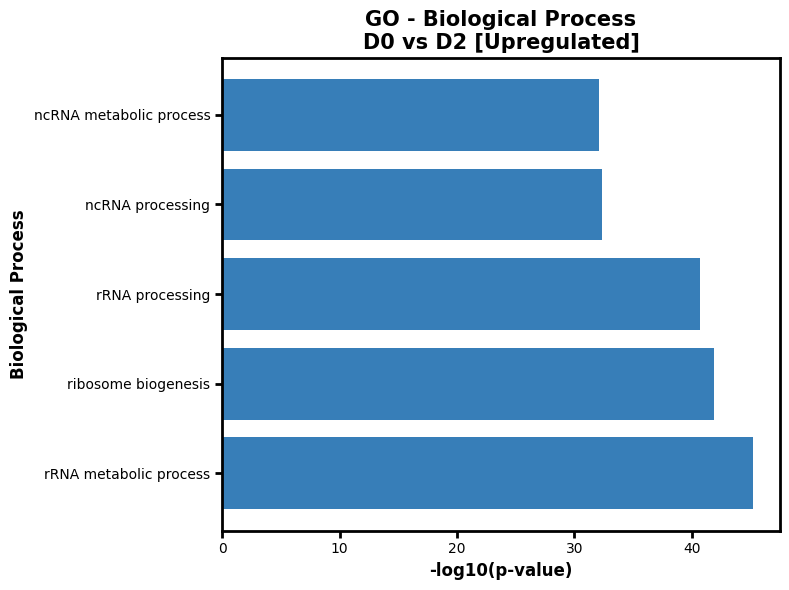

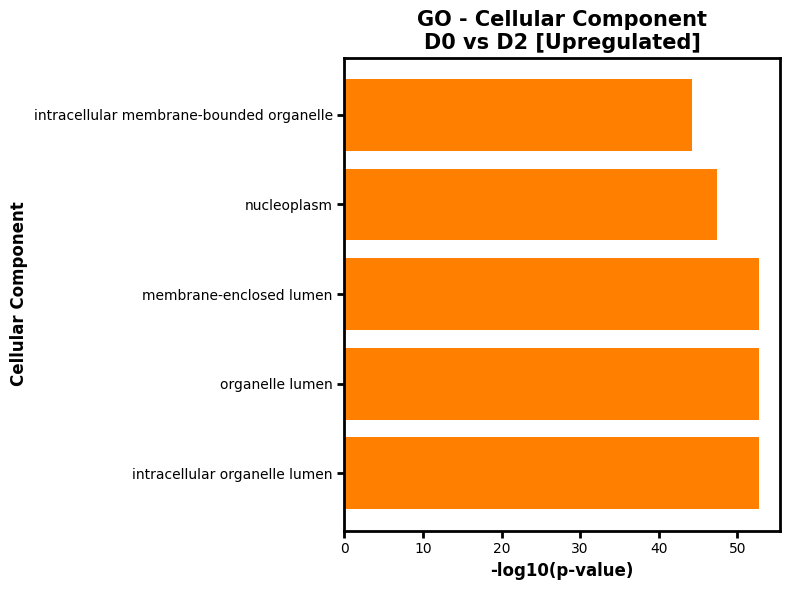

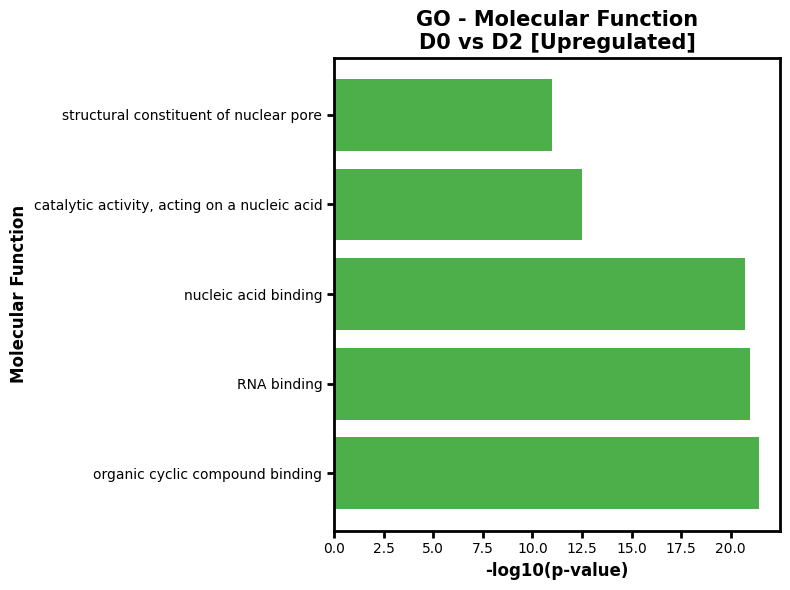

In [ ]:
#@title **GO plots for all proteins from a given experimental group comparison - Upregulated Proteins**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from gprofiler import GProfiler
import os


plt.rcParams['font.family'] = 'DejaVu Sans'
file_options = [f for f in os.listdir('TABLES/VOLCANO_PLOT_VALUES') if f.endswith('_Upregulated.csv')]
file_dropdown = widgets.Dropdown(
    options=file_options,
    description='Select File:',
    style={'description_width': 'initial'}
)

gp = GProfiler(return_dataframe=True)

def perform_go_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['GO:BP', 'GO:CC', 'GO:MF'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def customize_plot():
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(fontsize=10)
    plt.grid(False)
    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

def plot_go_results(results, source, color, ylabel, title, comparison_name):
    if not results.empty:
        plt.figure(figsize=(8, 6))
        plt.barh(results['name'], -np.log10(results['p_value']), color=color)
        plt.xlabel('-log10(p-value)', fontweight='bold', fontsize=12)
        plt.ylabel(ylabel, fontweight='bold', fontsize=12)
        plt.title(f'{title}\n{comparison_name} [Upregulated]', fontweight='bold', fontsize=15)
        customize_plot()
        plt.tight_layout()
        plt.savefig(f'PLOTS/{ylabel}_{comparison_name}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print(f"No significant {ylabel} results to plot.")

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)


def on_button_click(b):
    selected_file = file_dropdown.value
    data = pd.read_csv(f'TABLES/VOLCANO_PLOT_VALUES/{selected_file}', sep=',')

    comparison_name = data['Comparison'].iloc[0]

    group_genes = data['Genes'].unique().tolist()
    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    if not group_genes:
        print("No genes found in the selected file.")
        return

    selected_organism = organism_dropdown.value
    significant_results = perform_go_analysis(group_genes, selected_organism)

    if significant_results.empty:
        print("No significant results found.")
        return

    bp_results = significant_results[significant_results['source'] == 'GO:BP'].nsmallest(5, 'p_value')
    cc_results = significant_results[significant_results['source'] == 'GO:CC'].nsmallest(5, 'p_value')
    mf_results = significant_results[significant_results['source'] == 'GO:MF'].nsmallest(5, 'p_value')

    plot_go_results(bp_results, 'GO:BP', '#377eb8', 'Biological Process', 'GO - Biological Process', comparison_name)
    plot_go_results(cc_results, 'GO:CC', '#ff7f00', 'Cellular Component', 'GO - Cellular Component', comparison_name)
    plot_go_results(mf_results, 'GO:MF', '#4daf4a', 'Molecular Function', 'GO - Molecular Function', comparison_name)

plot_button.on_click(on_button_click)
display(file_dropdown, organism_dropdown, plot_button)


Dropdown(description='Select File:', options=('D0 vs D2_Downregulated.csv',), style=DescriptionStyle(descripti…

Dropdown(description='Organism:', options=('hsapiens', 'mmusculus', 'scerevisiae'), style=DescriptionStyle(des…

Button(description='Display Plot', layout=Layout(height='40px', width='auto'), style=ButtonStyle(button_color=…

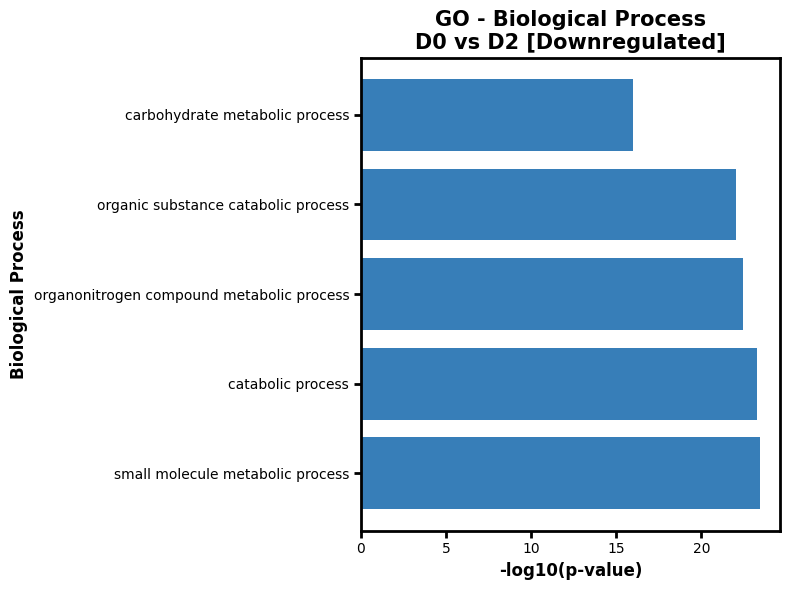

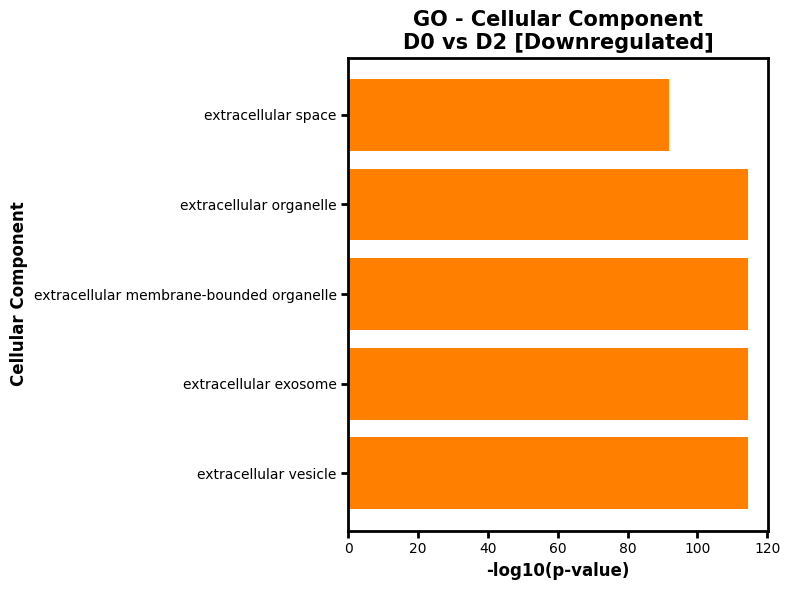

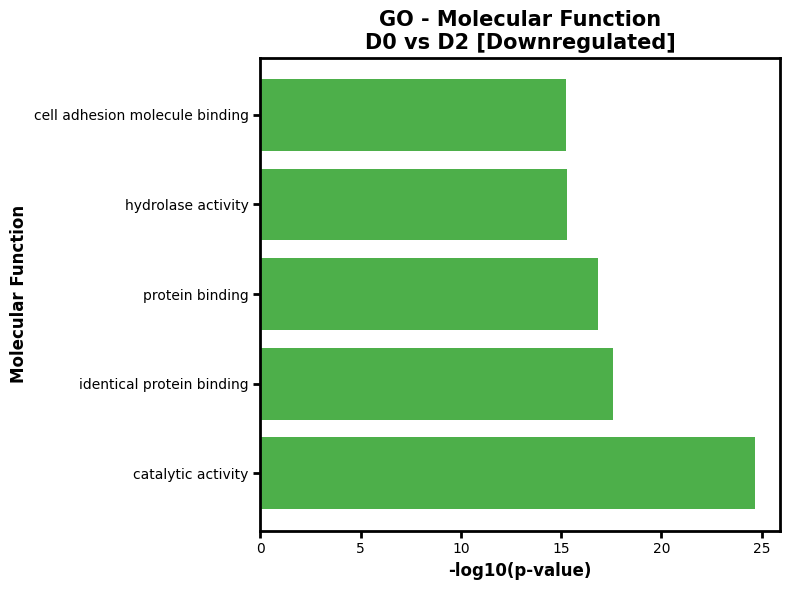

In [ ]:
#@title **GO plots for all proteins from a given experimental group comparison - Downregulated Proteins**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from gprofiler import GProfiler
import os


plt.rcParams['font.family'] = 'DejaVu Sans'
file_options = [f for f in os.listdir('TABLES/VOLCANO_PLOT_VALUES') if f.endswith('_Downregulated.csv')]
file_dropdown = widgets.Dropdown(
    options=file_options,
    description='Select File:',
    style={'description_width': 'initial'}
)

gp = GProfiler(return_dataframe=True)

def perform_go_analysis(genes, organism):
    results = gp.profile(organism=organism, query=genes, sources=['GO:BP', 'GO:CC', 'GO:MF'])
    significant_results = results[results['p_value'] < 0.05]
    return significant_results

def customize_plot():
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(fontsize=10)
    plt.grid(False)
    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

def plot_go_results(results, source, color, ylabel, title, comparison_name):
    if not results.empty:
        plt.figure(figsize=(8, 6))
        plt.barh(results['name'], -np.log10(results['p_value']), color=color)
        plt.xlabel('-log10(p-value)', fontweight='bold', fontsize=12)
        plt.ylabel(ylabel, fontweight='bold', fontsize=12)
        plt.title(f'{title}\n{comparison_name} [Downregulated]', fontweight='bold', fontsize=15)
        customize_plot()
        plt.tight_layout()
        plt.savefig(f'PLOTS/{ylabel}_{comparison_name}.tiff', dpi=300, format='tiff')
        plt.show()
    else:
        print(f"No significant {ylabel} results to plot.")

organism_dropdown = widgets.Dropdown(
    options=['hsapiens', 'mmusculus', 'scerevisiae'],
    description='Organism:',
    style={'description_width': 'initial'}
)

plot_button = widgets.Button(
    description="Display Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='40px')
)


def on_button_click(b):
    selected_file = file_dropdown.value
    data = pd.read_csv(f'TABLES/VOLCANO_PLOT_VALUES/{selected_file}', sep=',')

    comparison_name = data['Comparison'].iloc[0]

    group_genes = data['Genes'].unique().tolist()
    group_genes = [gene for gene in group_genes if pd.notna(gene)]

    if not group_genes:
        print("No genes found in the selected file.")
        return

    selected_organism = organism_dropdown.value
    significant_results = perform_go_analysis(group_genes, selected_organism)

    if significant_results.empty:
        print("No significant results found.")
        return

    bp_results = significant_results[significant_results['source'] == 'GO:BP'].nsmallest(5, 'p_value')
    cc_results = significant_results[significant_results['source'] == 'GO:CC'].nsmallest(5, 'p_value')
    mf_results = significant_results[significant_results['source'] == 'GO:MF'].nsmallest(5, 'p_value')

    plot_go_results(bp_results, 'GO:BP', '#377eb8', 'Biological Process', 'GO - Biological Process', comparison_name)
    plot_go_results(cc_results, 'GO:CC', '#ff7f00', 'Cellular Component', 'GO - Cellular Component', comparison_name)
    plot_go_results(mf_results, 'GO:MF', '#4daf4a', 'Molecular Function', 'GO - Molecular Function', comparison_name)

plot_button.on_click(on_button_click)
display(file_dropdown, organism_dropdown, plot_button)


##**Heatmaps**

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein name', 'Genes'), style=Descr…

Text(value='', description='Name:', layout=Layout(width='auto'), placeholder='Enter Protein name or Genes sepa…

Text(value='', description='Title:', layout=Layout(width='auto'), placeholder='Enter Heatmap Title', style=Des…

Button(description='Generate Heatmap', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_co…

The following names were not found in the dataset: ACTL6B, DPF1, DPF3, SMARCD3, SS18L1, ACTB


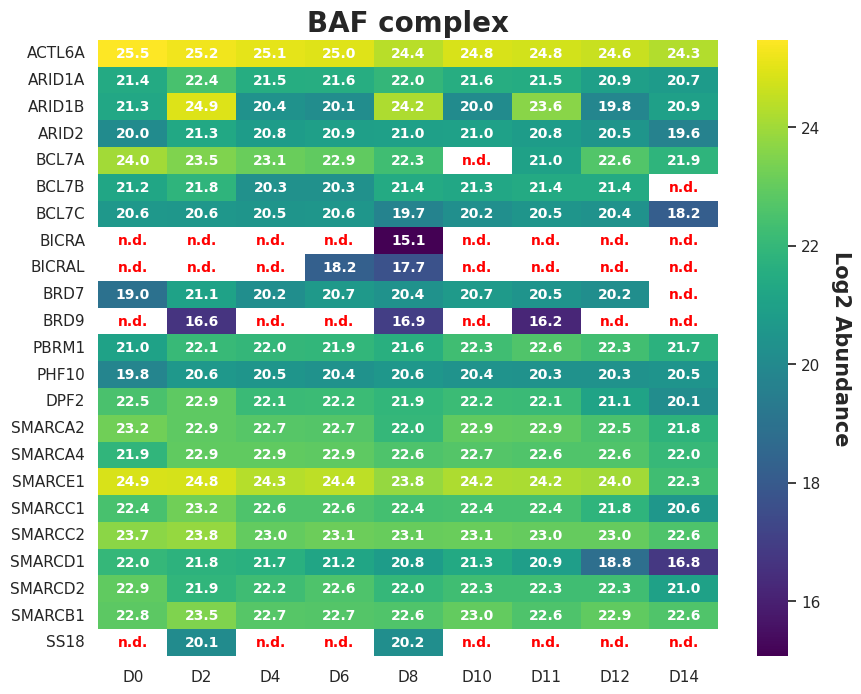

In [ ]:
#@title **Heatmap with no clustering for target protein/gene per experimental group**
#@markdown - Abundance values are subjected to log2 normalization methods
#@markdown - values of each replicate are displayed
#@markdown - Missing values are displayed as "n.d" or not detectable

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)

protein_input = widgets.Text(
    value='',
    placeholder='Enter Protein name or Genes separated by commas',
    description='Name:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

search_by_input = widgets.Dropdown(
    options=['Protein name', 'Genes'],
    value='Protein name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

title_input = widgets.Text(
    value='',
    placeholder='Enter Heatmap Title',
    description='Title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(description="Generate Heatmap", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(
    width='auto',
    height='80px'
))

def generate_heatmap(names, search_by, title):
    desired_order = [name.strip() for name in names.split(',')]

    if search_by == 'Protein name':
        filtered_data = data[data['Protein name'].isin(desired_order)]
        index_column = 'Protein name'
    elif search_by == 'Genes':
        filtered_data = data[data['Genes'].isin(desired_order)]
        index_column = 'Genes'
    else:
        print(f"Invalid search criteria: {search_by}")
        return

    found_names = filtered_data[index_column].tolist()
    not_found_names = [name for name in desired_order if name not in found_names]

    if not found_names:
        print(f"No data found for {search_by}: {names}")
        return

    if not_found_names:
        print(f"The following names were not found in the dataset: {', '.join(not_found_names)}")

    valid_columns = data.columns[3:]
    filtered_data = filtered_data[[index_column] + list(valid_columns)]
    filtered_data.set_index(index_column, inplace=True)
    filtered_data = filtered_data.loc[found_names]
    filtered_data = filtered_data.apply(pd.to_numeric, errors='coerce')

    log2_values = np.log2(filtered_data)

    sns.set(font_scale=1.0)
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(data=log2_values, cmap="viridis", annot=False, fmt=".1f", linewidths=0, linecolor='black', yticklabels=True)

    for i, (name, values) in enumerate(log2_values.iterrows()):
        for j, value in enumerate(values):
            if pd.notna(value):
                plt.text(j + 0.5, i + 0.5, f"{value:.1f}", ha="center", va="center", color="white", fontsize=10, fontweight="bold")
            else:
                plt.text(j + 0.5, i + 0.5, "n.d.", ha="center", va="center", color="red", fontsize=10, fontweight="bold")

    heatmap.set_ylabel("", fontweight='bold', fontsize=20)
    cbar = heatmap.collections[0].colorbar
    cbar.set_label("Log2 Abundance", fontsize=15, labelpad=15, rotation=270, verticalalignment='center', fontweight='bold')
    plt.setp(plt.gca(), facecolor='none')
    plt.title(title, fontsize=20, fontweight='bold')
    file_name = f'PLOTS/Heatmap_no_clustering_experimental_groups_log2_{title.replace(" ", "_")}.tiff'
    plt.savefig(file_name, format='tiff', dpi=300, bbox_inches='tight')

    plt.show()

def on_button_click(b):
    generate_heatmap(protein_input.value, search_by_input.value, title_input.value)

button.on_click(on_button_click)

display(search_by_input, protein_input, title_input, button)

##**Heatmaps using imputation**

<Figure size 800x800 with 0 Axes>

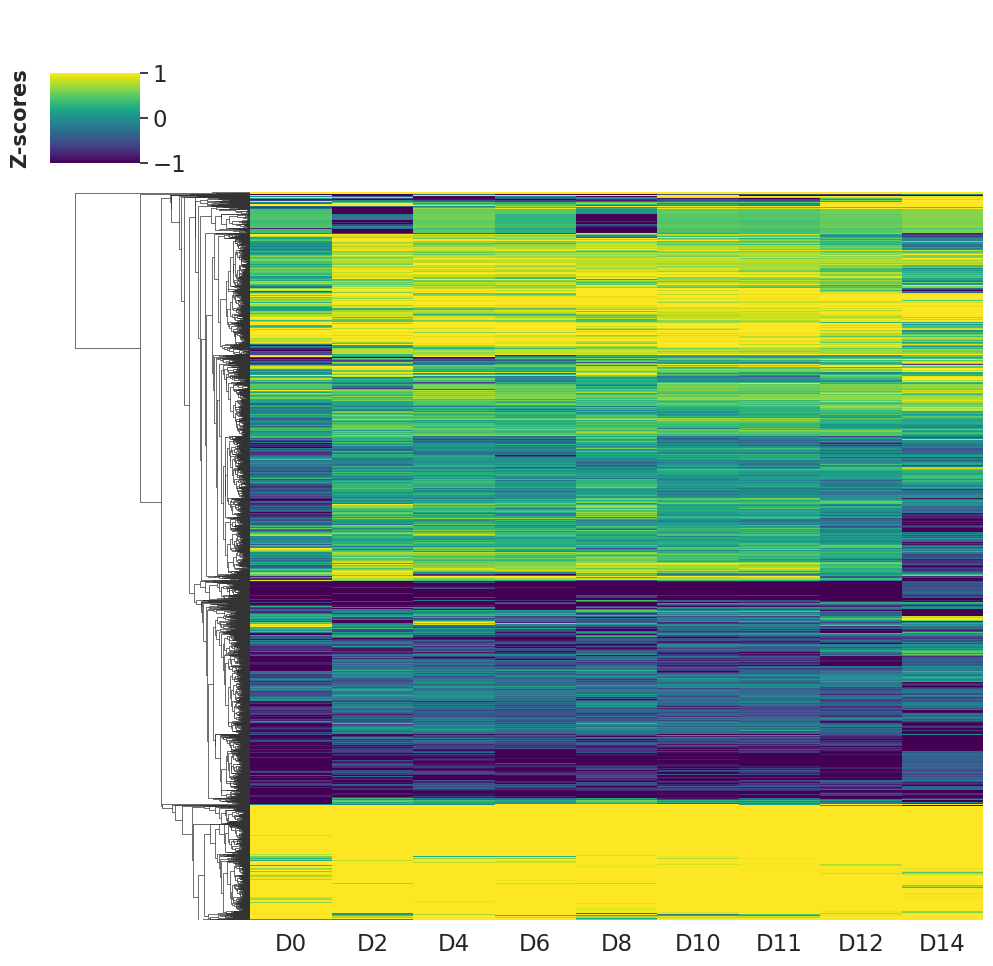

In [ ]:
#@title **Hierarchical clustering heatmap for experimental groups**
#@markdown - Abundance values are subjected to log2 and z-score normalization methods

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)

data = data.drop(columns=['Genes'])
valid_columns = data.columns[2:].tolist()

filtered_data = data[['Protein name'] + valid_columns].copy()
filtered_data.set_index('Protein name', inplace=True)

imputer = IterativeImputer()
imputed_data = imputer.fit_transform(filtered_data)
imputed_df = pd.DataFrame(imputed_data, index=filtered_data.index, columns=filtered_data.columns)
log2_data = imputed_df.apply(lambda col: col.map(lambda x: np.log2(float(x)) if pd.notnull(x) and float(x) > 0 else np.nan))
z_scores_df = (log2_data - log2_data.mean()) / log2_data.std()
z_scores_df.replace([np.inf, -np.inf], np.nan, inplace=True)
z_scores_df.dropna(inplace=True)

sns.set(font_scale=1.5)
plt.figure(figsize=(8, 8))
cmap = sns.color_palette("viridis", as_cmap=True)
heatmap = sns.clustermap(data=z_scores_df, cmap=cmap, annot=False, fmt=".1f", linewidths=0, linecolor='black', yticklabels=False, vmin=-1, vmax=1, col_cluster=False, cbar_pos=(0.01, 0.82, 0.09, 0.09))
heatmap.ax_heatmap.set_ylabel("", fontweight='bold', fontsize=20)
cbar = heatmap.ax_heatmap.collections[0].colorbar
cbar.set_label("Z-scores", fontsize=15, labelpad=-120, rotation=90, verticalalignment='center', fontweight='bold')
plt.savefig('PLOTS/Clustering_Heatmap_total_proteome_Iterative_imputation.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x800 with 0 Axes>

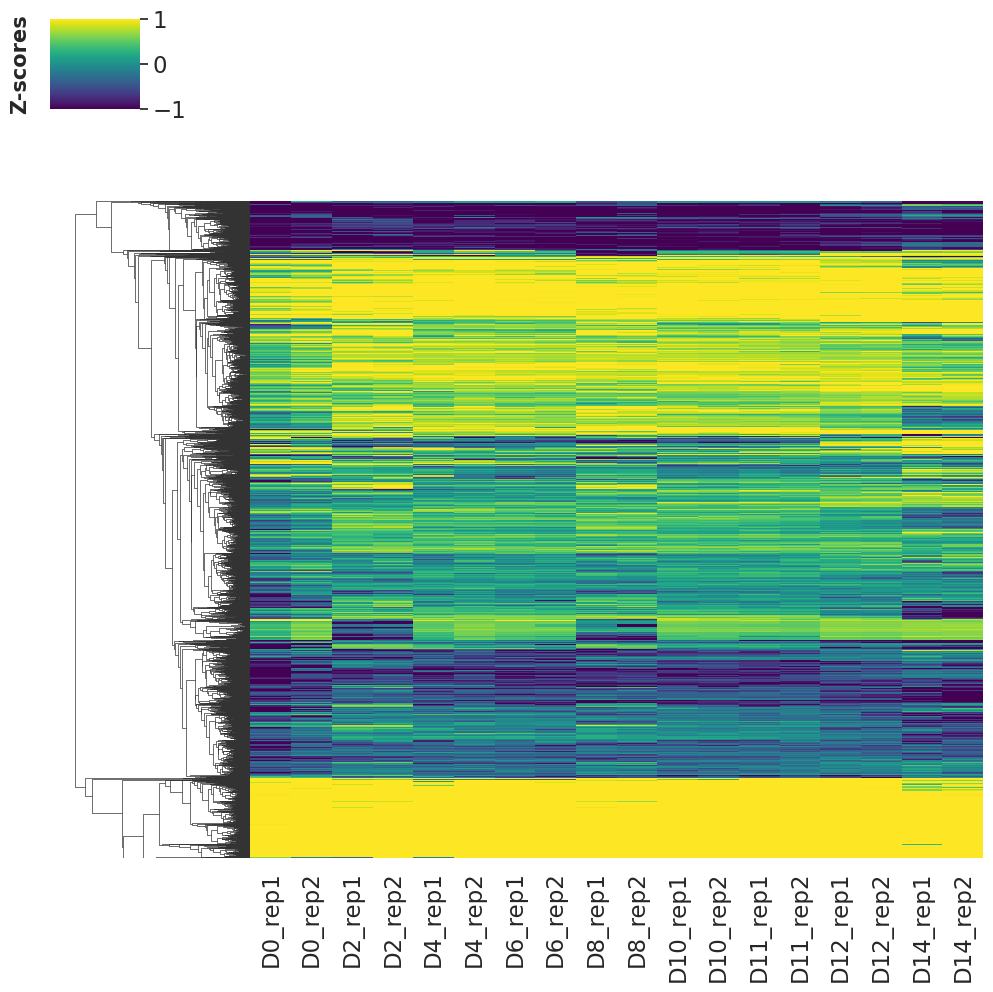

In [ ]:
#@title **Hierarchical clustering heatmap for each sample**
#@markdown - Abundance values are subjected to log2 and z-score normalization methods

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

warnings.filterwarnings("ignore", category=ConvergenceWarning)

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/melted_protein_data_samples.csv'
data = pd.read_csv(file_path)

data = data.drop(columns=['Genes'])
valid_columns = data.columns[2:].tolist()
filtered_data = data[['Protein name'] + valid_columns].copy()
filtered_data.set_index('Protein name', inplace=True)


imputer = IterativeImputer(max_iter=100, random_state=0)
imputed_data = imputer.fit_transform(filtered_data)
imputed_df = pd.DataFrame(imputed_data, index=filtered_data.index, columns=filtered_data.columns)

log2_data = imputed_df.apply(lambda col: col.map(lambda x: np.log2(float(x)) if pd.notnull(x) and float(x) > 0 else np.nan))
z_scores_df = (log2_data - log2_data.mean()) / log2_data.std()
z_scores_df.replace([np.inf, -np.inf], np.nan, inplace=True)
z_scores_df.dropna(inplace=True)


sns.set(font_scale=1.5)
plt.figure(figsize=(8, 8))
cmap = sns.color_palette("viridis", as_cmap=True)
heatmap = sns.clustermap(data=z_scores_df, cmap=cmap, annot=False, fmt=".1f", linewidths=0, linecolor='black', yticklabels=False, vmin=-1, vmax=1, col_cluster=False, cbar_pos=(0.01, 0.9, 0.09, 0.09))
heatmap.ax_heatmap.set_ylabel("", fontweight='bold', fontsize=20)
cbar = heatmap.ax_heatmap.collections[0].colorbar
cbar.set_label("Z-scores", fontsize=15, labelpad=-120, rotation=90, verticalalignment='center', fontweight='bold')
plt.savefig('PLOTS/Heatmap_total_proteome_samples_Iterative_imputation.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()


